In [1]:
import psycopg2
from datetime import timedelta
from sqlalchemy import create_engine
import psycopg2
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score,f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sktime.transformations.panel.rocket import Rocket
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold

In [2]:
import psycopg2

conn = psycopg2.connect(
    host="localhost",
    database="mimic",
    user="postgres",
    password="postgres"
)

cur = conn.cursor()

cur.execute("SELECT version();")
print(cur.fetchone())

('PostgreSQL 15.2, compiled by Visual C++ build 1914, 64-bit',)


In [ ]:
# Connect to db
conn = psycopg2.connect(host='localhost', dbname='mimic', user='postgres', password='postgres', options='-c search_path=mimiciii')
cur = conn.cursor() 

# Read in table with patients & admissions (inner join on subject_id) and icu_stays (inner joinon subject_id and hadm_id)
icustay_details = pd.read_sql_query("SELECT * FROM mimiciii.flicu_icustay_detail;", conn)

# Read in vital and lab signs
pivoted_vital = pd.read_sql_query("SELECT * FROM mimiciii.pivoted_vital;", conn)
pivoted_lab = pd.read_sql_query("SELECT * FROM mimiciii.ckd_pivoted_lab;", conn)

# Close the cursor and connection to so the server can allocate bandwidth to other requests
cur.close()
conn.close()

C:\Users\aakru\anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\aakru\anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\aakru\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\aakru\AppData\Local\Temp\ipykernel_15076\3511136484.py", line 9, in <module>
    pivoted_vital = pd.read_sql_query("SELECT * FROM mimiciii.pivoted_vital;", conn)
  File "C:\Users\aakru\anaconda3\lib\site-packages\pandas\io\sql.py", line 400, in read_sql_query
    return pandas_sql.read_query(
  File "C:\Users\aakru\anaconda3\lib\site-packages\pandas\io\sql.py", line 2100, in read_query
    frame = _wrap_result(
  File "C:\Users\aakru\anaconda3\lib\site-packages\pandas\io\sql.py", line 151, in _wrap_result
    frame = DataFrame.from_records(data, columns=columns, coerce_float=coerce_float)
  File "C:\Users\aakru\anaconda3\lib\site-packages\pandas\core\frame.py", line 2154, in from_records
    columns = ensure_index(columns)
  File "C:\Users\aakru\anaconda3\lib\site-packages\p

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\aakru\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\aakru\AppData\Local\Temp\ipykernel_15076\3511136484.py", line 9, in <module>
    pivoted_vital = pd.read_sql_query("SELECT * FROM mimiciii.pivoted_vital;", conn)
  File "C:\Users\aakru\anaconda3\lib\site-packages\pandas\io\sql.py", line 400, in read_sql_query
    return pandas_sql.read_query(
  File "C:\Users\aakru\anaconda3\lib\site-packages\pandas\io\sql.py", line 2100, in read_query
    frame = _wrap_result(
  File "C:\Users\aakru\anaconda3\lib\site-packages\pandas\io\sql.py", line 151, in _wrap_result
    frame = DataFrame.from_records(data, columns=columns, coerce_float=coerce_float)
  File "C:\Users\aakru\anaconda3\lib\site-packages\pandas\core\frame.py", line 2154, in from_records
    columns = ensure_index(columns)
  File "C:\Users\aakru\anaconda3\lib\site-packages\p

In [3]:
WINDOW_LENGTH = 96

In [4]:
data= icustay_details.copy()
data = data[data.los_icu >= WINDOW_LENGTH/24.0]

ERROR! Session/line number was not unique in database. History logging moved to new session 203


In [5]:
filtered_icustay_ids = pd.DataFrame(data['icustay_id'].unique(), columns=['icustay_id'])

In [6]:
# Drop measurements with no belonging icustay_id
pivoted_vital = pivoted_vital.dropna(subset=['icustay_id'])
pivoted_lab = pivoted_lab.dropna(subset=['icustay_id'])

# Cast icustay_id types to int
pivoted_vital['icustay_id'] = pivoted_vital['icustay_id'].astype(int)
pivoted_lab['icustay_id'] = pivoted_lab['icustay_id'].astype(int)

# Keep only values of patients in previously filtered icustay_ids in labs and vitals
pivoted_vital = pivoted_vital.merge(filtered_icustay_ids, on='icustay_id', how='right').drop_duplicates()
pivoted_lab = pivoted_lab.merge(filtered_icustay_ids, on='icustay_id', how='right').drop_duplicates()

NameError: name 'pivoted_vital' is not defined

In [8]:
# Min of each lab and vitals
icustay_ids_charttime_min_lab = pivoted_lab[["icustay_id", "charttime"]][pivoted_lab.groupby("icustay_id")["charttime"].rank(ascending=1,method='dense') == 1]
icustay_ids_charttime_min_vital = pivoted_vital[["icustay_id", "charttime"]][pivoted_vital.groupby("icustay_id")["charttime"].rank(ascending=1,method='dense') == 1]
# Min of both combined
icustay_ids_charttime_min_vital_lab = pd.concat([icustay_ids_charttime_min_lab, icustay_ids_charttime_min_vital], ignore_index=True)
icustay_ids_charttime_min_vital_lab = icustay_ids_charttime_min_vital_lab[["icustay_id", "charttime"]][icustay_ids_charttime_min_vital_lab.groupby("icustay_id")["charttime"].rank(ascending=1,method='dense') == 1]

# Max of each lab and vitals
icustay_ids_charttime_max_lab = pivoted_lab[["icustay_id", "charttime"]][pivoted_lab.groupby("icustay_id")["charttime"].rank(ascending=0,method='dense') == 1]
icustay_ids_charttime_max_vital = pivoted_vital[["icustay_id", "charttime"]][pivoted_vital.groupby("icustay_id")["charttime"].rank(ascending=0,method='dense') == 1]
# Max of both combined
icustay_ids_charttime_max_vital_lab = pd.concat([icustay_ids_charttime_max_lab, icustay_ids_charttime_max_vital], ignore_index=True)
icustay_ids_charttime_max_vital_lab = icustay_ids_charttime_max_vital_lab[["icustay_id", "charttime"]][icustay_ids_charttime_max_vital_lab.groupby("icustay_id")["charttime"].rank(ascending=0,method='dense') == 1]

In [9]:
# Find for which icustay_ids there exist at least WINDOW_LENGTH of data
icustay_ids_vital_lab_charttime_min_max = pd.concat([icustay_ids_charttime_max_vital_lab, icustay_ids_charttime_min_vital_lab], ignore_index=True)
time_window = timedelta(days=4, seconds=0, microseconds=0, milliseconds=0, minutes=0, hours=WINDOW_LENGTH, weeks=0)
is_time_diff_bigger_window_lab = icustay_ids_vital_lab_charttime_min_max.groupby(['icustay_id'])['charttime'].transform(lambda x: (x.max()-x.min())) >= time_window

icustay_ids_vital_lab_charttime_min_max_filtered = icustay_ids_vital_lab_charttime_min_max[is_time_diff_bigger_window_lab]
print("Unique icu stays in icustay_ids_vital_lab_charttime_min_max_filtered after filtering", icustay_ids_vital_lab_charttime_min_max_filtered['icustay_id'].nunique())

# Keep only icustay ids for which at least WINDOW_LENGTH of data exists
icustay_ids_time_filtered = pd.DataFrame(icustay_ids_vital_lab_charttime_min_max_filtered['icustay_id'].unique(), columns=['icustay_id'])
print("Unique icu stays in icustay_ids_time_filtered: ", icustay_ids_time_filtered['icustay_id'].nunique())

Unique icu stays in icustay_ids_vital_lab_charttime_min_max_filtered after filtering 8409
Unique icu stays in icustay_ids_time_filtered:  8409


In [10]:
filtered_icustay_ids = filtered_icustay_ids.merge(icustay_ids_time_filtered, on='icustay_id', how='inner').drop_duplicates()

In [11]:
demographics_filtered = data.merge(filtered_icustay_ids, on='icustay_id', how='right').drop_duplicates()
print("Number of ICU stays demographics: ", demographics_filtered['icustay_id'].nunique())

vital_filtered = pivoted_vital.merge(filtered_icustay_ids, on='icustay_id', how='right').drop_duplicates()
print("Number of ICU stays vitals: ", vital_filtered['icustay_id'].nunique())

lab_filtered = pivoted_lab.merge(filtered_icustay_ids, on='icustay_id', how='right').drop_duplicates()
print("Number of ICU stays labs: ", lab_filtered['icustay_id'].nunique())

Number of ICU stays demographics:  8409
Number of ICU stays vitals:  8409
Number of ICU stays labs:  8409


In [12]:
vital_filtered = vital_filtered.merge(lab_filtered[['icustay_id', 'charttime']], on=['icustay_id', 'charttime'], how='outer').drop_duplicates()
print("Number of ICU stays in lab_filtered: ", vital_filtered['icustay_id'].nunique())
lab_filtered = lab_filtered.merge(vital_filtered[['icustay_id', 'charttime']], on=['icustay_id', 'charttime'], how='outer').drop_duplicates()
print("Number of ICU stays in lab_filtered: ", lab_filtered['icustay_id'].nunique())

Number of ICU stays in lab_filtered:  8409
Number of ICU stays in lab_filtered:  8409


In [13]:
vital_resampled = vital_filtered.copy()

# Resample from the end of the time series (how="last")
vital_resampled = vital_resampled.assign(charttime=vital_resampled.charttime.dt.round('H'))

# Resample from the beginning of the time series
vital_resampled = vital_resampled.set_index('charttime').groupby('icustay_id').resample('1H', origin="start").median().drop(['icustay_id'], axis = 1).reset_index()

# Forward and backwards fill (use lambda function instead of directly applying it to groupby otherwise results from one group are carreid forward to another group...BAD)
# Fill NaNs (-1)
vital_col = vital_resampled.columns.drop(['icustay_id', 'charttime'])
vital_resampled = vital_resampled.set_index(['icustay_id', 'charttime']).groupby('icustay_id')[vital_col].transform(lambda x: x.ffill().bfill()).fillna(value=vital_resampled[['icustay_id', 'charttime', 'heartrate', 'sysbp', 'diasbp', 'meanbp','resprate', 'tempc', 'spo2', 'glucose', 'rbc', 'specificgravity','pedaledema', 'appetite_median']].median()).reset_index()


C:\Users\navim\AppData\Local\Temp\ipykernel_1852\2079071312.py:12: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  vital_resampled = vital_resampled.set_index(['icustay_id', 'charttime']).groupby('icustay_id')[vital_col].transform(lambda x: x.ffill().bfill()).fillna(value=vital_resampled[['icustay_id', 'charttime', 'heartrate', 'sysbp', 'diasbp', 'meanbp','resprate', 'tempc', 'spo2', 'glucose', 'rbc', 'specificgravity','pedaledema', 'appetite_median']].median()).reset_index()


In [14]:
lab_resampled = lab_filtered.copy()
# Cut out minutes and hours, so that the resampling of the 8h takes the same time span as the 1h samples (for vitals)
lab_resampled = lab_resampled.assign(charttime=lab_resampled.charttime.dt.round('H'))
# Resample from the end of the time series 
#lab_resampled = lab_resampled.set_index('charttime').groupby('icustay_id').resample('8h', origin="end").median().drop(['icustay_id'], axis = 1).reset_index()
lab_resampled = lab_resampled.set_index('charttime').groupby('icustay_id').resample('8h', origin="start").median().drop(['icustay_id'], axis = 1).reset_index()

# Forward and backwards fill (use transform instead of direct groupby otherwise results from one group are carreid forward to another group...BAD)
# Fill NaNs (-1 or 0 or mean!?)
lab_col = lab_resampled.columns.drop(['icustay_id', 'charttime'])
lab_resampled = lab_resampled.set_index(['icustay_id', 'charttime']).groupby('icustay_id')[lab_col].transform(lambda x: x.ffill().bfill()).fillna(value=lab_resampled[['icustay_id', 'subject_id', 'charttime', 'aniongap', 'albumin', 'bands','bicarbonate', 'bilirubin', 'creatinine', 'chloride', 'glucose','hematocrit', 'hemoglobin', 'lactate', 'platelet', 'potassium', 'ptt','inr', 'pt', 'sodium', 'bun', 'wbc', 'bacteria']].median()).reset_index()

print(lab_resampled.isnull().sum().sum())

C:\Users\navim\AppData\Local\Temp\ipykernel_1852\3063204683.py:11: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  lab_resampled = lab_resampled.set_index(['icustay_id', 'charttime']).groupby('icustay_id')[lab_col].transform(lambda x: x.ffill().bfill()).fillna(value=lab_resampled[['icustay_id', 'subject_id', 'charttime', 'aniongap', 'albumin', 'bands','bicarbonate', 'bilirubin', 'creatinine', 'chloride', 'glucose','hematocrit', 'hemoglobin', 'lactate', 'platelet', 'potassium', 'ptt','inr', 'pt', 'sodium', 'bun', 'wbc', 'bacteria']].median()).reset_index()


730


In [15]:
delta_t_data = timedelta(days=0, seconds=0, microseconds=0, milliseconds=0, minutes=0, hours=WINDOW_LENGTH, weeks=0)
demographics_windowed = demographics_filtered.copy()
demographics_windowed['predtime'] = demographics_windowed.intime + delta_t_data
demographics_windowed['delta_t_pred'] = demographics_windowed.outtime - demographics_windowed.predtime

demographics_windowed[['subject_id', 'icustay_id', 'intime', 'predtime', 'delta_t_pred']].head(5)

,subject_id,icustay_id,intime,predtime,delta_t_pred
0,334,214236,2136-01-16 10:56:48,2136-01-20 10:56:48,10 days 07:21:18
1,2005,285731,2163-06-23 11:28:06,2163-06-27 11:28:06,5 days 08:45:56
2,12174,284866,2118-10-30 16:48:57,2118-11-03 16:48:57,13 days 00:44:12
3,13535,205010,2196-10-10 22:03:14,2196-10-14 22:03:14,88 days 19:52:36
4,21824,241223,2107-07-07 20:58:00,2107-07-11 20:58:00,31 days 15:33:00


In [16]:
cut_icustay_ids = pd.DataFrame(demographics_windowed['icustay_id'].unique(), columns=['icustay_id'])
print("Number of ICU stays: ", cut_icustay_ids['icustay_id'].count())

vitals_cut = vital_resampled.merge(cut_icustay_ids, on='icustay_id', how='right')
print("Number of ICU stays in vitals_cut: ", vitals_cut['icustay_id'].nunique())

labs_cut = lab_resampled.merge(cut_icustay_ids, on='icustay_id', how='right')
print("Number of ICU stays in labs_cut: ", labs_cut['icustay_id'].nunique())


Number of ICU stays:  8409
Number of ICU stays in vitals_cut:  8409
Number of ICU stays in labs_cut:  8409


In [17]:
vitals_windowed = vital_resampled.merge(demographics_windowed[['icustay_id', 'predtime', 'delta_t_pred']], on='icustay_id', how='right')
vitals_windowed = vitals_windowed[vitals_windowed.charttime < vitals_windowed.predtime]
print("Number of ICU stays in vitals_windowed: ", vitals_windowed['icustay_id'].nunique())

labs_windowed = lab_resampled.merge(demographics_windowed[['icustay_id', 'predtime', 'delta_t_pred']], on='icustay_id', how='right')
labs_windowed = labs_windowed[labs_windowed.charttime < labs_windowed.predtime]
print("Number of ICU stays in labs_windowed: ", labs_windowed['icustay_id'].nunique())

windowed_icustay_ids = pd.DataFrame(pd.concat([vitals_windowed['icustay_id'], labs_windowed['icustay_id']]).unique(), columns=['icustay_id'])
demographics_windowed = demographics_windowed.merge(windowed_icustay_ids, on='icustay_id', how='right')

Number of ICU stays in vitals_windowed:  8405
Number of ICU stays in labs_windowed:  8405


In [18]:
vitals_windowed['ckd'] = vitals_windowed['icustay_id'].map(demographics_windowed.set_index('icustay_id')['ckd'])

In [19]:
vitals_windowed =vitals_windowed.set_index(['icustay_id', 'charttime']).groupby('icustay_id')[vital_col].transform(lambda x: x.ffill().bfill()).fillna(-1).reset_index()

In [20]:
labs_windowed['ckd'] = labs_windowed['icustay_id'].map(demographics_windowed.set_index('icustay_id')['ckd'])

In [21]:
print("Number of ICU stays demographics: ", demographics_windowed['icustay_id'].nunique())
print("Number of CKD demographics:")
dd = demographics_windowed[['icustay_id','ckd']].drop_duplicates(subset=['icustay_id'])
print(dd['ckd'].value_counts())

print("Number of ICU stays vitals: ", vitals_windowed['icustay_id'].nunique())
print("Number of CKD vitals:")
dd = vitals_windowed[['icustay_id','ckd']].drop_duplicates(subset=['icustay_id'])
print(dd['ckd'].value_counts())

print("Number of ICU stays labs: ", labs_windowed['icustay_id'].nunique())
print("Number of CKD labs:")
dd = labs_windowed[['icustay_id','ckd']].drop_duplicates(subset=['icustay_id'])
print(dd['ckd'].value_counts())

Number of ICU stays demographics:  8405
Number of CKD demographics:
0    7868
1     537
Name: ckd, dtype: int64
Number of ICU stays vitals:  8405
Number of CKD vitals:
0    7868
1     537
Name: ckd, dtype: int64
Number of ICU stays labs:  8405
Number of CKD labs:
0    7868
1     537
Name: ckd, dtype: int64


In [22]:
def aggregate_dataframe(df, groupby_key, columns_to_aggregate):
    df = df.replace(-1, np.nan)
    result = df.groupby(groupby_key)[columns_to_aggregate].mean().reset_index()    
    return result

In [23]:
columns_to_merge = ['icustay_id', 'ckd','ethnicity_grouped']
df_cols_vitals = ['heartrate', 'sysbp','diasbp','meanbp','resprate','tempc','spo2','specificgravity','pedaledema','appetite_median']
df_agg_vitals = aggregate_dataframe(vitals_windowed, 'icustay_id', df_cols_vitals)
df_agg_vitals = df_agg_vitals.merge(demographics_windowed[columns_to_merge], on='icustay_id', how='inner')
df_agg_vitals['ckd_ethnicity'] = df_agg_vitals['ckd'].astype(str).str.cat(df_agg_vitals['ethnicity_grouped'].astype(str))

df_cols_labs = ['albumin','bacteria','glucose','bun','creatinine','sodium','potassium','hemoglobin','wbc','hematocrit','platelet','ptt']
df_agg_labs = aggregate_dataframe(labs_windowed, 'icustay_id', df_cols_labs)
df_agg_labs = df_agg_labs.merge(demographics_windowed[columns_to_merge], on='icustay_id', how='inner')
df_agg_labs['ckd_ethnicity'] = df_agg_labs['ckd'].astype(str).str.cat(df_agg_labs['ethnicity_grouped'].astype(str))

print("Vitals unique icustay id: ",len(df_agg_vitals['icustay_id'].unique()),"\nLabs unique icustay id: ",len(df_agg_labs['icustay_id'].unique()),"\nDemographics unique icustay id: ",len(demographics_windowed['icustay_id'].unique()))

Vitals unique icustay id:  8405 
Labs unique icustay id:  8405 
Demographics unique icustay id:  8405


In [24]:
df_agg_vitals_new=df_agg_vitals.drop(['ckd','ethnicity_grouped','ckd_ethnicity','pedaledema'],axis=1)
df_agg_labs_new=df_agg_labs.drop(['ckd','ethnicity_grouped','ckd_ethnicity'],axis=1)

In [25]:
merged_table_org = df_agg_labs_new.merge(df_agg_vitals_new, on='icustay_id', how='inner').merge(demographics_windowed, on='icustay_id', how='inner')

In [26]:
merged_table =merged_table_org.copy()

Table names : 
- demographics_windowed
- labs_windowed
- vitals_windowed
- df_agg_vitals
- df_agg_labs
- merged_table_org

In [27]:
# Calculate the difference between max and min charttime for labs_windowed
labs_diff = labs_windowed.groupby('icustay_id')['charttime'].apply(lambda x: x.max() - x.min())

# Calculate the difference between max and min charttime for vitals_windowed
vitals_diff = vitals_windowed.groupby('icustay_id')['charttime'].apply(lambda x: x.max() - x.min())

# Filter the icustay_id where the difference is grater than or equal to Window_length in both labs and vitals
filtered_icustay_ids = labs_diff[(labs_diff == pd.Timedelta(hours=WINDOW_LENGTH)) & (vitals_diff == pd.Timedelta(hours=WINDOW_LENGTH))].index.tolist()

# Print the length of icustay_id
print(len(filtered_icustay_ids))

3038


In [28]:
merged_table_filtered= merged_table[merged_table['icustay_id'].isin(filtered_icustay_ids)]

In [29]:
merged_table_filtered.columns

Index(['icustay_id', 'albumin', 'bacteria', 'glucose', 'bun', 'creatinine',
       'sodium', 'potassium', 'hemoglobin', 'wbc', 'hematocrit', 'platelet',
       'ptt', 'heartrate', 'sysbp', 'diasbp', 'meanbp', 'resprate', 'tempc',
       'spo2', 'specificgravity', 'appetite_median', 'subject_id', 'hadm_id',
       'gender', 'dod', 'admittime', 'dischtime', 'los_hospital',
       'admission_age', 'ethnicity', 'ethnicity_grouped',
       'hospital_expire_flag', 'hospstay_seq', 'first_hosp_stay', 'intime',
       'outtime', 'los_icu', 'icustay_seq', 'first_icu_stay_current_hosp',
       'first_icu_stay_patient', 'first_careunit', 'deathtime_icu',
       'label_death_icu', 'label_cor_art', 'diabetes_mellitus', 'ckd',
       'anemia_flag', 'predtime', 'delta_t_pred'],
      dtype='object')

In [30]:
merged_table_filtered=merged_table_filtered.drop(['subject_id','hadm_id','dod','admittime', 'dischtime','los_hospital','ethnicity','hospital_expire_flag','hospstay_seq', 'first_hosp_stay', 'intime','outtime', 'los_icu', 'icustay_seq', 'first_icu_stay_current_hosp','first_icu_stay_patient', 'first_careunit', 'deathtime_icu','label_death_icu', 'predtime', 'delta_t_pred'],axis=1)

In [31]:
age_ranges = [0, 9, 19, 29, 39, 49, 59, 69, 79, 89, 400]
age_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']
merged_table_filtered['age_group'] = pd.cut(merged_table_filtered['admission_age'], bins=age_ranges, labels=age_labels, right=False)
merged_table_filtered=merged_table_filtered.drop('admission_age',axis=1)

In [32]:
def evaluationCV(classifier,X, y):    
    cv_scores_pr = cross_val_score(classifier, X, y, cv=5, scoring='precision')    
    cv_scores_rc = cross_val_score(classifier, X, y, cv=5, scoring='recall')    
    cv_scores_f1 = cross_val_score(classifier,X, y, cv=5, scoring='f1')
    cv_scores_ac = cross_val_score(classifier, X, y, cv=5, scoring='accuracy') 
    
    print("Cross-validation scores Precision    :", cv_scores_pr)    
    print("Cross-validation scores Recall       :", cv_scores_rc)
    print("Cross-validation scores F1           :", cv_scores_f1)
    print("Cross-validation scores Accuracy     :", cv_scores_ac)
    
    print("Mean cross-validation score Precision:", np.mean(cv_scores_pr))
    print("Mean cross-validation score Recall   :", np.mean(cv_scores_rc))
    print("Mean cross-validation score F1       :", np.mean(cv_scores_f1))
    print("Mean cross-validation score Accuracy :", np.mean(cv_scores_ac))

In [33]:
def evaluationTest(classifier,X, y):  
    y_pred = classifier.predict(X)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    accuracy = accuracy_score(y, y_pred)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Accuracy:", accuracy)
    
    print(classification_report(y, y_pred))
    
    return pd.DataFrame(y_pred)    

In [34]:
def metricsReport(y,y_pred):
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    accuracy = accuracy_score(y, y_pred)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Accuracy:", accuracy)
    
    print(classification_report(y, y_pred))
    
    return precision, recall , f1, accuracy

#### Data & Class separation

In [35]:
X = merged_table_filtered.drop(['ckd','icustay_id'],axis=1)
y = merged_table_filtered['ckd']

#### Trial 1:  Random forest for static + aggregated timeseries

In [36]:
X_onehot = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X_onehot, y, test_size=0.20, stratify=y, random_state=42)

In [37]:
y_train.value_counts()

0    2305
1     125
Name: ckd, dtype: int64

In [38]:
y_test.value_counts()

0    577
1     31
Name: ckd, dtype: int64

In [39]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

In [40]:
param_grid_rcv = {
    'n_estimators': randint(50, 500),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : randint(1, 10),
    'criterion' :['gini', 'entropy']
}

In [41]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2','auto']
}

In [42]:
#runder = RandomUnderSampler(random_state=42)
#X_resampled, y_resampled = runder.fit_resample(X_train, y_train)
rf_merged = RandomForestClassifier(random_state=42)

#grid_search = RandomizedSearchCV(estimator=rf_merged, param_distributions=param_grid_rcv, n_iter=100, cv=5, random_state=42)

#grid_search = GridSearchCV(rf_merged, param_grid, cv=5)
#grid_search.fit(X_train, y_train)
#grid_search.best_params_

In [43]:
evaluationCV(rf_merged,X_train, y_train)

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cross-validation scores Precision    : [0. 0. 0. 0. 0.]
Cross-validation scores Recall       : [0. 0. 0. 0. 0.]
Cross-validation scores F1           : [0. 0. 0. 0. 0.]
Cross-validation scores Accuracy     : [0.94855967 0.94444444 0.94855967 0.94855967 0.94650206]
Mean cross-validation score Precision: 0.0
Mean cross-validation score Recall   : 0.0
Mean cross-validation score F1       : 0.0
Mean cross-validation score Accuracy : 0.9473251028806585


In [44]:
rf_merged_2 = RandomForestClassifier(random_state=42,
                                     max_depth = None, 
                                     max_features = 'sqrt',
                                     min_samples_leaf = 1,
                                     min_samples_split = 1,
                                     n_estimators= 100)

rf_merged_2.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=1, random_state=42)

In [45]:
evaluationCV(rf_merged_2,X_train, y_train)

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cross-validation scores Precision    : [0. 0. 0. 0. 0.]
Cross-validation scores Recall       : [0. 0. 0. 0. 0.]
Cross-validation scores F1           : [0. 0. 0. 0. 0.]
Cross-validation scores Accuracy     : [0.94855967 0.94444444 0.94855967 0.94855967 0.94650206]
Mean cross-validation score Precision: 0.0
Mean cross-validation score Recall   : 0.0
Mean cross-validation score F1       : 0.0
Mean cross-validation score Accuracy : 0.9473251028806585


In [46]:
y_pred_merged_2 = evaluationTest(rf_merged_2,X_test, y_test)

Precision: 0.5
Recall: 0.03225806451612903
F1 Score: 0.06060606060606061
Accuracy: 0.9490131578947368
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       577
           1       0.50      0.03      0.06        31

    accuracy                           0.95       608
   macro avg       0.73      0.52      0.52       608
weighted avg       0.93      0.95      0.93       608



In [47]:
y_pred_merged_2.value_counts()

0    606
1      2
dtype: int64

#### Trial 2 - RandomUnderSampler

In [48]:
X_top =X[['creatinine', 'specificgravity', 'heartrate', 'bun', 'spo2', 'tempc', 'platelet', 'diasbp', 'bacteria', 'meanbp']]
X_onehot = pd.get_dummies(X_top)
X_train, X_test, y_train, y_test = train_test_split(X_onehot, y, test_size=0.20, stratify=y, random_state=42)

undersampler = RandomUnderSampler()
#undersampler = RandomUnderSampler(sampling_strategy={0: 250})
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

rf_ros = RandomForestClassifier(random_state=42,
                                max_depth = None, 
                                max_features = 'sqrt',
                                min_samples_leaf = 1,
                                min_samples_split = 1,
                                n_estimators= 100)

rf_ros.fit(X_resampled, y_resampled)
evaluationCV(rf_ros,X_resampled, y_resampled)

rf_ros.fit(X_resampled, y_resampled)
y_pred_ros = evaluationTest(rf_ros,X_test, y_test)
y_pred_ros.value_counts()

Cross-validation scores Precision    : [0.6969697  0.88       0.77777778 0.81481481 0.8       ]
Cross-validation scores Recall       : [0.92 0.88 0.84 0.88 0.8 ]
Cross-validation scores F1           : [0.79310345 0.88       0.80769231 0.84615385 0.8       ]
Cross-validation scores Accuracy     : [0.76 0.88 0.8  0.84 0.8 ]
Mean cross-validation score Precision: 0.7939124579124579
Mean cross-validation score Recall   : 0.8640000000000001
Mean cross-validation score F1       : 0.8253899204244032
Mean cross-validation score Accuracy : 0.8160000000000001
Precision: 0.14691943127962084
Recall: 1.0
F1 Score: 0.256198347107438
Accuracy: 0.7039473684210527
              precision    recall  f1-score   support

           0       1.00      0.69      0.82       577
           1       0.15      1.00      0.26        31

    accuracy                           0.70       608
   macro avg       0.57      0.84      0.54       608
weighted avg       0.96      0.70      0.79       608



0    397
1    211
dtype: int64

In [49]:
cm = confusion_matrix(y_test, y_pred_ros)
print(cm)

[[397 180]
 [  0  31]]


In [50]:
X_onehot = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X_onehot, y, test_size=0.20, stratify=y, random_state=42)

undersampler = RandomUnderSampler()
#undersampler = RandomUnderSampler(sampling_strategy={0: 250})
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

rf_ros = RandomForestClassifier(random_state=42,
                                max_depth = None, 
                                max_features = 'sqrt',
                                min_samples_leaf = 1,
                                min_samples_split = 1,
                                n_estimators= 100)

rf_ros.fit(X_resampled, y_resampled)
evaluationCV(rf_ros,X_resampled, y_resampled)

rf_ros.fit(X_resampled, y_resampled)
y_pred_ros = evaluationTest(rf_ros,X_test, y_test)
y_pred_ros.value_counts()

Cross-validation scores Precision    : [0.69230769 0.72413793 0.84615385 0.6875     0.76      ]
Cross-validation scores Recall       : [0.72 0.84 0.88 0.88 0.76]
Cross-validation scores F1           : [0.70588235 0.77777778 0.8627451  0.77192982 0.76      ]
Cross-validation scores Accuracy     : [0.7  0.76 0.86 0.74 0.76]
Mean cross-validation score Precision: 0.7420198938992042
Mean cross-validation score Recall   : 0.8160000000000001
Mean cross-validation score F1       : 0.7756670106639147
Mean cross-validation score Accuracy : 0.7639999999999999
Precision: 0.14285714285714285
Recall: 1.0
F1 Score: 0.25
Accuracy: 0.694078947368421
              precision    recall  f1-score   support

           0       1.00      0.68      0.81       577
           1       0.14      1.00      0.25        31

    accuracy                           0.69       608
   macro avg       0.57      0.84      0.53       608
weighted avg       0.96      0.69      0.78       608



0    391
1    217
dtype: int64

In [51]:
def cross_val_with_sampling(clf, X,y, resampling = None):
        
    X = X.values
    y = y.values
    label0_prec=0
    label0_rec=0
    label0_f1=0    
    label1_prec=0
    label1_rec=0
    label1_f1=0
    acc1 = 0
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        if resampling == None:
            print("CV : No resampling: Train:", y_train.shape[0] , "Test:", y_test.shape[0])
        elif (resampling.lower() == 'under'):
            sampler = RandomUnderSampler(random_state=42)
            X_train, y_train = sampler.fit_resample(X_train, y_train)
            print("CV: Under sampling: Train:", y_train.shape[0] , "Test:", y_test.shape[0])
        elif (resampling.lower() == 'over'):
            sampler = SMOTE(random_state=42)
            X_train, y_train = sampler.fit_resample(X_train, y_train)
            print("CV: Over sampling: Train:", y_train.shape[0] , "Test:", y_test.shape[0])
        
        clf.fit(X_train, y_train)
        #y_pred_validation = evaluationTest(clf, X_test, y_test)
        y_pred_validation = clf.predict(X_test)
        
        clf_res=classification_report(y_test,y_pred_validation,output_dict=True)
        label0, label1, acc=(clf_res['0'],clf_res['1'],clf_res['accuracy'])
        
        label0_prec+=label0['precision']
        label0_rec+=label0['recall']
        label0_f1+=label0['f1-score']        
        label1_prec+=label1['precision']
        label1_rec+=label1['recall']
        label1_f1+=label1['f1-score']        
        acc1+=acc
        
    print("label 0 precision ",label0_prec/5, "\nlabel 0 recall ", label0_rec/5,"\nlabel 0 f1 ",label0_f1/5)
    print("\n\nlabel 1 precision ",label1_prec/5, "\nlabel 1 recall ", label1_rec/5,"\nlabel 1 f1 ",label1_f1/5)
    print("\n\nAccuracy ",acc1/5)
    
    return clf, y_pred_validation

In [52]:
X = merged_table_filtered.drop(['ckd','icustay_id'],axis=1)
y = merged_table_filtered['ckd']

In [53]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
#X_onehot_train = pd.get_dummies(X_train)
#X_onehot_test = pd.get_dummies(X_test)
#
#rf_1, y_val = cross_val_with_sampling(rf_ros, X_onehot_train,y_train, resampling = "under")
#print("----------------------TEST-------------------------------------")
#evaluationTest(rf_1, X_onehot_test, y_test)

#### Trial 3: BRF

In [54]:
X_onehot = pd.get_dummies(X_top)
X_train, X_test, y_train, y_test = train_test_split(X_onehot, y, test_size=0.20, stratify=y, random_state=42)

ros = SMOTE(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

brf = BalancedRandomForestClassifier(n_estimators=100)
brf.fit(X_resampled, y_resampled)

evaluationCV(brf,X_resampled, y_resampled)

y_pred_brf = evaluationTest(brf,X_test, y_test)
y_pred_brf.value_counts()

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

Cross-validation scores Precision    : [0.93290043 0.93995859 0.95378151 0.93814433 0.94226804]
Cross-validation scores Recall       : [0.93058568 0.98264642 0.98264642 0.99349241 0.99566161]
Cross-validation scores F1           : [0.9326087  0.96186441 0.96478122 0.96828753 0.96822034]
Cross-validation scores Accuracy     : [0.93058568 0.96529284 0.96420824 0.96312364 0.96529284]
Mean cross-validation score Precision: 0.9414105817544002
Mean cross-validation score Recall   : 0.977006507592191
Mean cross-validation score F1       : 0.9591524368981654
Mean cross-validation score Accuracy : 0.957700650759219
Precision: 0.23684210526315788
Recall: 0.2903225806451613
F1 Score: 0.2608695652173913
Accuracy: 0.9161184210526315
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       577
           1       0.24      0.29      0.26        31

    accuracy                           0.92       608
   macro avg       0.60      0.62      0.61       60

0    570
1     38
dtype: int64

In [55]:
X_onehot = pd.get_dummies(X_top)
X_train, X_test, y_train, y_test = train_test_split(X_onehot, y, test_size=0.20, stratify=y, random_state=42)

undersampler = RandomUnderSampler()
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

brf = BalancedRandomForestClassifier(n_estimators=100)
brf.fit(X_resampled, y_resampled)

evaluationCV(brf,X_resampled, y_resampled)

y_pred_brf = evaluationTest(brf,X_test, y_test)
y_pred_brf.value_counts()

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

Cross-validation scores Precision    : [0.68965517 0.68965517 0.80769231 0.91304348 0.7037037 ]
Cross-validation scores Recall       : [0.88 0.88 0.8  0.8  0.76]
Cross-validation scores F1           : [0.73684211 0.76363636 0.80769231 0.875      0.72      ]
Cross-validation scores Accuracy     : [0.74 0.74 0.78 0.88 0.72]
Mean cross-validation score Precision: 0.7607499668968934
Mean cross-validation score Recall   : 0.8240000000000001
Mean cross-validation score F1       : 0.7806341553183659
Mean cross-validation score Accuracy : 0.7719999999999999
Precision: 0.15151515151515152
Recall: 0.967741935483871
F1 Score: 0.26200873362445415
Accuracy: 0.7220394736842105
              precision    recall  f1-score   support

           0       1.00      0.71      0.83       577
           1       0.15      0.97      0.26        31

    accuracy                           0.72       608
   macro avg       0.57      0.84      0.55       608
weighted avg       0.95      0.72      0.80       608



C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\U

0    410
1    198
dtype: int64

# 2. Experiments

demographics_windowed

merged_table

--------------------------------
static_demo_comorb

labs_windowed

vitals_windowed

In [56]:
age_ranges = [0, 9, 19, 29, 39, 49, 59, 69, 79, 89, 400]
age_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']
demographics_windowed['age_group'] = pd.cut(merged_table['admission_age'], bins=age_ranges, labels=age_labels, right=False)

In [57]:
static_demo_comorb = demographics_windowed[['icustay_id','gender', 'ethnicity_grouped', 'label_cor_art', 'diabetes_mellitus', 'anemia_flag', 'age_group', 'ckd']]

In [58]:
# Get the unique icustay_id values from each DataFrame
icustay_id_df1 = set(static_demo_comorb['icustay_id'])
icustay_id_df2 = set(labs_windowed['icustay_id'])
icustay_id_df3 = set(vitals_windowed['icustay_id'])

# Check for missing icustay_id values
missing_from_df1 = icustay_id_df2.union(icustay_id_df3) - icustay_id_df1
missing_from_df2 = icustay_id_df1.union(icustay_id_df3) - icustay_id_df2
missing_from_df3 = icustay_id_df1.union(icustay_id_df2) - icustay_id_df3

# Print the missing icustay_id values
if missing_from_df1:
    print(f"Icustay_id missing from static_demo_comorb: {missing_from_df1}")
else:
    print("No icustay_id missing from static_demo_comorb")

if missing_from_df2:
    print(f"Icustay_id missing from labs_windowed: {missing_from_df2}")
else:
    print("No icustay_id missing from labs_windowed")

if missing_from_df3:
    print(f"Icustay_id missing from vitals_windowed: {missing_from_df3}")
else:
    print("No icustay_id missing from vitals_windowed")



No icustay_id missing from static_demo_comorb
No icustay_id missing from labs_windowed
No icustay_id missing from vitals_windowed


In [59]:
# Calculate the difference between max and min charttime for labs_windowed
labs_diff = labs_windowed.groupby('icustay_id')['charttime'].apply(lambda x: x.max() - x.min()).to_frame()
labs_diff.min()

charttime   2 days 16:00:00
dtype: timedelta64[ns]

In [60]:
# Calculate the difference between max and min charttime for vitals_windowed
vitals_diff = vitals_windowed.groupby('icustay_id')['charttime'].apply(lambda x: x.max() - x.min()).to_frame()
vitals_diff.min()

charttime   2 days 23:00:00
dtype: timedelta64[ns]

In [61]:
WINDOW_LENGTH_NEW = 96

In [62]:
filtered_icustay_ids = labs_diff[(labs_diff == pd.Timedelta(hours=WINDOW_LENGTH_NEW)) & (vitals_diff == pd.Timedelta(hours=WINDOW_LENGTH_NEW))].index.tolist()
print("Total : ",len(filtered_icustay_ids))
print(static_demo_comorb['ckd'].value_counts())

Total :  8405
0    7868
1     537
Name: ckd, dtype: int64


## 2.1 Random Forest - Comorbidity & Demographics

In [253]:
def RandomForestForMulti(X_train, X_test, y_train, y_test, resampling=None):        
    if resampling == None:
        print("No resampling: Train:", y_train.shape[0] , "Test:", y_test.shape[0])
    elif resampling.lower() == 'under':
        sampler = RandomUnderSampler()
        X_train, y_train = sampler.fit_resample(X_train, y_train)
        print("under sampling: Train:", y_train.shape[0] , "Test:", y_test.shape[0])
    elif resampling.lower() == 'over':
        sampler = SMOTE()
        X_train, y_train = sampler.fit_resample(X_train, y_train)
        print("over sampling: Train:", y_train.shape[0] , "Test:", y_test.shape[0])
    
    #rf_static_demo_comorb = RandomForestClassifier(n_estimators=300, random_state=42)
        
    rf_static_demo_comorb_best = RandomForestClassifier(n_estimators=200, 
                                                        max_depth=None,
                                                        min_samples_leaf=2,
                                                        min_samples_split=2,
                                                        max_features='sqrt',
                                                        random_state=42)
    
    rf_static_demo_comorb_best.fit(X_train, y_train)
    
    rf_static_demo_comorb_best, y_val = cross_val_with_sampling(rf_static_demo_comorb_best, X_train,y_train, resampling = resampling)
    
    y_pred = evaluationTest(rf_static_demo_comorb_best,X_test, y_test)
    
    #f1 = f1_score(y_test, y_pred)
    #weight = np.log(f1/(1-f1))
    
    acc = accuracy_score(y_test, y_pred)
    weight = np.log(acc/(1-acc))  
    
    proba = rf_static_demo_comorb_best.predict_proba(X_test)
    
    return rf_static_demo_comorb_best, weight, proba    

In [64]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

X=static_demo_comorb.drop(['ckd','icustay_id'],axis=1)
y=static_demo_comorb['ckd']

X_onehot=pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X_onehot, y, test_size=0.2,stratify = y, random_state=42)
rf_default, _, _ = RandomForestForMulti(X_train, X_test, y_train, y_test)

No resampling: Train: 6724 Test: 1681
CV : No resampling: Train: 5379 Test: 1345


C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

CV : No resampling: Train: 5379 Test: 1345
CV : No resampling: Train: 5379 Test: 1345
CV : No resampling: Train: 5379 Test: 1345
CV : No resampling: Train: 5380 Test: 1344
label 0 precision  0.9369977813264647 
label 0 recall  0.9995234312946784 
label 0 f1  0.9672510436099617


label 1 precision  0.5666666666666667 
label 1 recall  0.01627906976744186 
label 1 f1  0.03161389172625127


Accuracy  0.9366449814126394
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Accuracy: 0.9363474122546104
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1574
           1       0.00      0.00      0.00       107

    accuracy                           0.94      1681
   macro avg       0.47      0.50      0.48      1681
weighted avg       0.88      0.94      0.91      1681



C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMet

In [65]:
X=static_demo_comorb.drop(['ckd','icustay_id'],axis=1)
y=static_demo_comorb['ckd']

X_onehot=pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X_onehot, y, test_size=0.2,stratify = y, random_state=42)
rf_under_sampled, _, _ = RandomForestForMulti(X_train, X_test, y_train, y_test, resampling='under')

under sampling: Train: 860 Test: 1681
CV: Under sampling: Train: 688 Test: 172
CV: Under sampling: Train: 688 Test: 172
CV: Under sampling: Train: 688 Test: 172
CV: Under sampling: Train: 688 Test: 172
CV: Under sampling: Train: 688 Test: 172
label 0 precision  0.5828742316148426 
label 0 recall  0.6558139534883721 
label 0 f1  0.6169824794735487


label 1 precision  0.6063924963924964 
label 1 recall  0.530232558139535 
label 1 f1  0.5654332504959053


Accuracy  0.5930232558139534
Precision: 0.11952191235059761
Recall: 0.5607476635514018
F1 Score: 0.19704433497536947
Accuracy: 0.709101725163593
              precision    recall  f1-score   support

           0       0.96      0.72      0.82      1574
           1       0.12      0.56      0.20       107

    accuracy                           0.71      1681
   macro avg       0.54      0.64      0.51      1681
weighted avg       0.91      0.71      0.78      1681



C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [66]:
X=static_demo_comorb.drop(['ckd','icustay_id'],axis=1)
y=static_demo_comorb['ckd']

X_onehot=pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X_onehot, y, test_size=0.2,stratify = y, random_state=42)
rf_over_sampled, _, _ = RandomForestForMulti(X_train, X_test, y_train, y_test, resampling='over')

over sampling: Train: 12588 Test: 1681
CV: Over sampling: Train: 10070 Test: 2518
CV: Over sampling: Train: 10070 Test: 2518
CV: Over sampling: Train: 10070 Test: 2518
CV: Over sampling: Train: 10072 Test: 2517
CV: Over sampling: Train: 10072 Test: 2517
label 0 precision  0.6720557878937503 
label 0 recall  0.7495991342461463 
label 0 f1  0.708437663823539


label 1 precision  0.7175933220645894 
label 1 recall  0.6339401776209701 
label 1 f1  0.6727419408407387


Accuracy  0.691769770169677
Precision: 0.09771309771309772
Recall: 0.4392523364485981
F1 Score: 0.1598639455782313
Accuracy: 0.7061273051754908
              precision    recall  f1-score   support

           0       0.95      0.72      0.82      1574
           1       0.10      0.44      0.16       107

    accuracy                           0.71      1681
   macro avg       0.52      0.58      0.49      1681
weighted avg       0.90      0.71      0.78      1681



C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [67]:
X=static_demo_comorb.drop(['ckd','icustay_id'],axis=1)
y=static_demo_comorb['ckd']

X_onehot=pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X_onehot, y, test_size=0.2,stratify = y, random_state=42)
rf_over_sampled, _, _ = RandomForestForMulti(X_train, X_test, y_train, y_test, resampling='over')

over sampling: Train: 12588 Test: 1681
CV: Over sampling: Train: 10070 Test: 2518
CV: Over sampling: Train: 10070 Test: 2518
CV: Over sampling: Train: 10070 Test: 2518
CV: Over sampling: Train: 10072 Test: 2517
CV: Over sampling: Train: 10072 Test: 2517
label 0 precision  0.6782162678704159 
label 0 recall  0.734506529142795 
label 0 f1  0.7042859919265488


label 1 precision  0.7115205047997559 
label 1 recall  0.6498125420659646 
label 1 f1  0.6778577101534471


Accuracy  0.6921667845307982
Precision: 0.09915611814345991
Recall: 0.4392523364485981
F1 Score: 0.16179001721170397
Accuracy: 0.710291493158834
              precision    recall  f1-score   support

           0       0.95      0.73      0.82      1574
           1       0.10      0.44      0.16       107

    accuracy                           0.71      1681
   macro avg       0.52      0.58      0.49      1681
weighted avg       0.90      0.71      0.78      1681



C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\navim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


## Aggregated Static model

In [68]:
merged_table_agg=merged_table.drop(['subject_id','hadm_id','dod','admittime', 'dischtime','los_hospital','ethnicity','hospital_expire_flag','hospstay_seq', 'first_hosp_stay', 'intime','outtime', 'los_icu', 'icustay_seq', 'first_icu_stay_current_hosp','first_icu_stay_patient', 'first_careunit', 'deathtime_icu','label_death_icu', 'predtime', 'delta_t_pred'],axis=1)

ethnicities_to_drop = ["middle_eastern", "portuguese", "alaska_native", "pacific_islander"]
merged_table_agg    = merged_table_agg[~merged_table_agg['ethnicity_grouped'].isin(ethnicities_to_drop)]

In [119]:
X=merged_table_agg.drop(['ckd'],axis=1)
y=merged_table_agg['ckd']

X_onehot=pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X_onehot, y, test_size=0.2,stratify = y, random_state=42)

test_ids_reuse = X_test['icustay_id']

X_train= X_train.drop(['icustay_id'],axis=1)
X_test = X_test.drop(['icustay_id'],axis=1)

In [120]:
rf_default_agg, _, _ = RandomForestForMulti(X_train, X_test, y_train, y_test)

No resampling: Train: 6692 Test: 1673
CV : No resampling: Train: 5353 Test: 1339
CV : No resampling: Train: 5353 Test: 1339
CV : No resampling: Train: 5354 Test: 1338
CV : No resampling: Train: 5354 Test: 1338
CV : No resampling: Train: 5354 Test: 1338
label 0 precision  0.9379594482768987 
label 0 recall  0.9988826815642458 
label 0 f1  0.9674624282607288


label 1 precision  0.6857142857142856 
label 1 recall  0.028207934336525308 
label 1 f1  0.053801699762988785


Accuracy  0.9370890084852382
Precision: 0.625
Recall: 0.09345794392523364
F1 Score: 0.16260162601626016
Accuracy: 0.9384339509862523
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1566
           1       0.62      0.09      0.16       107

    accuracy                           0.94      1673
   macro avg       0.78      0.54      0.57      1673
weighted avg       0.92      0.94      0.92      1673



In [121]:
rf_under_agg, _, _ = RandomForestForMulti(X_train, X_test, y_train, y_test, resampling='under')

under sampling: Train: 852 Test: 1673
CV: Under sampling: Train: 680 Test: 171
CV: Under sampling: Train: 680 Test: 171
CV: Under sampling: Train: 682 Test: 170
CV: Under sampling: Train: 682 Test: 170
CV: Under sampling: Train: 682 Test: 170
label 0 precision  0.8756214012409412 
label 0 recall  0.7465663474692203 
label 0 f1  0.8047038505025906


label 1 precision  0.7797842877203008 
label 1 recall  0.8920383036935705 
label 1 f1  0.8314124400475773


Accuracy  0.8192019263845889
Precision: 0.18285714285714286
Recall: 0.897196261682243
F1 Score: 0.30379746835443033
Accuracy: 0.7369994022713688
              precision    recall  f1-score   support

           0       0.99      0.73      0.84      1566
           1       0.18      0.90      0.30       107

    accuracy                           0.74      1673
   macro avg       0.59      0.81      0.57      1673
weighted avg       0.94      0.74      0.80      1673



In [122]:
rf_over_agg, _, _ = RandomForestForMulti(X_train, X_test, y_train, y_test, resampling='over')

over sampling: Train: 12532 Test: 1673
CV: Over sampling: Train: 10026 Test: 2507
CV: Over sampling: Train: 10026 Test: 2507
CV: Over sampling: Train: 10026 Test: 2506
CV: Over sampling: Train: 10026 Test: 2506
CV: Over sampling: Train: 10026 Test: 2506
label 0 precision  0.9765429012235363 
label 0 recall  0.9562710738247345 
label 0 f1  0.9662953283657689


label 1 precision  0.9571691077969406 
label 1 recall  0.977019491338809 
label 1 f1  0.9669875354420003


Accuracy  0.9666451891606933
Precision: 0.3805309734513274
Recall: 0.40186915887850466
F1 Score: 0.3909090909090909
Accuracy: 0.9199043634190077
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1566
           1       0.38      0.40      0.39       107

    accuracy                           0.92      1673
   macro avg       0.67      0.68      0.67      1673
weighted avg       0.92      0.92      0.92      1673



#### Without ethnicity

In [123]:
X_train_no_eth= X_train.drop(['ethnicity_grouped_asian','ethnicity_grouped_black',   'ethnicity_grouped_hispanic', 
'ethnicity_grouped_unknown', 'ethnicity_grouped_white'],axis=1)

X_test_no_eth= X_test.drop(['ethnicity_grouped_asian','ethnicity_grouped_black',   'ethnicity_grouped_hispanic', 
'ethnicity_grouped_unknown', 'ethnicity_grouped_white'],axis=1)

In [124]:
rf_default_noeth, _, _ = RandomForestForMulti(X_train_no_eth, X_test_no_eth, y_train, y_test)

No resampling: Train: 6692 Test: 1673
CV : No resampling: Train: 5353 Test: 1339
CV : No resampling: Train: 5353 Test: 1339
CV : No resampling: Train: 5354 Test: 1338
CV : No resampling: Train: 5354 Test: 1338
CV : No resampling: Train: 5354 Test: 1338
label 0 precision  0.9385987723012045 
label 0 recall  0.9977654904147112 
label 0 f1  0.9672775447028237


label 1 precision  0.5461111111111111 
label 1 recall  0.039890560875512994 
label 1 f1  0.07389435822219087


Accuracy  0.9367898315566912
Precision: 0.6153846153846154
Recall: 0.07476635514018691
F1 Score: 0.13333333333333333
Accuracy: 0.9378362223550508
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1566
           1       0.62      0.07      0.13       107

    accuracy                           0.94      1673
   macro avg       0.78      0.54      0.55      1673
weighted avg       0.92      0.94      0.91      1673



In [125]:
rf_under_noeth, _, _ = RandomForestForMulti(X_train_no_eth, X_test_no_eth, y_train, y_test, resampling='under')

under sampling: Train: 852 Test: 1673
CV: Under sampling: Train: 680 Test: 171
CV: Under sampling: Train: 680 Test: 171
CV: Under sampling: Train: 682 Test: 170
CV: Under sampling: Train: 682 Test: 170
CV: Under sampling: Train: 682 Test: 170
label 0 precision  0.849036232155332 
label 0 recall  0.6994254445964432 
label 0 f1  0.7668524082827498


label 1 precision  0.7446764285877092 
label 1 recall  0.8756497948016415 
label 1 f1  0.8047902009878672


Accuracy  0.787533539731682
Precision: 0.19675456389452334
Recall: 0.9065420560747663
F1 Score: 0.3233333333333333
Accuracy: 0.7573221757322176
              precision    recall  f1-score   support

           0       0.99      0.75      0.85      1566
           1       0.20      0.91      0.32       107

    accuracy                           0.76      1673
   macro avg       0.59      0.83      0.59      1673
weighted avg       0.94      0.76      0.82      1673



In [126]:
rf_over_noeth, _, _ = RandomForestForMulti(X_train_no_eth, X_test_no_eth, y_train, y_test, resampling='over')

over sampling: Train: 12532 Test: 1673
CV: Over sampling: Train: 10026 Test: 2507
CV: Over sampling: Train: 10026 Test: 2507
CV: Over sampling: Train: 10026 Test: 2506
CV: Over sampling: Train: 10026 Test: 2506
CV: Over sampling: Train: 10026 Test: 2506
label 0 precision  0.9776844767936638 
label 0 recall  0.9570697948527999 
label 0 f1  0.9672567781536753


label 1 precision  0.9579749072102242 
label 1 recall  0.9781360460572456 
label 1 f1  0.9679409686677991


Accuracy  0.9676028270085582
Precision: 0.3805309734513274
Recall: 0.40186915887850466
F1 Score: 0.3909090909090909
Accuracy: 0.9199043634190077
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1566
           1       0.38      0.40      0.39       107

    accuracy                           0.92      1673
   macro avg       0.67      0.68      0.67      1673
weighted avg       0.92      0.92      0.92      1673



In [129]:
#X_train_no_eth_alcr= X_train_no_eth.drop(['albumin','creatinine'],axis=1)
#X_test_no_eth_alcr= X_test_no_eth.drop(['albumin','creatinine'],axis=1)

In [135]:
#rf_default_noeth_alcr, _, _ = RandomForestForMulti(X_train_no_eth_alcr, X_test_no_eth_alcr, y_train, y_test)

In [136]:
#rf_over_noeth_alcr, _, _ = RandomForestForMulti(X_train_no_eth_alcr, X_test_no_eth_alcr, y_train, y_test, resampling='over')

In [137]:
#X_train_alcr= X_train_no_eth[['albumin','creatinine']]
#X_test_alcr= X_test_no_eth[['albumin','creatinine']]

In [138]:
#rf_over_alcr, _, _ = RandomForestForMulti(X_train_alcr, X_test_alcr, y_train, y_test,resampling='over')

## 2.2 Time series - Data preparation

In [79]:
def print_unique_shape(grouped_data,feature_cols):
    previous_shape = []
    for _, group in grouped_data:
        group_values = group[feature_cols].values.T
        if group_values.shape not in previous_shape:        
            print(group_values.shape)
            previous_shape.append(group_values.shape)

In [80]:
def check_shape_in_grouped_df(data_grouped, feature_cols, icustay_id):
    for _, group in data_grouped:
        if(group['icustay_id'].values[0]==icustay_id):
            group_values = group[feature_cols].values.T
            return group_values.shape

In [81]:
def check_missing_and_extras(data_windowed,feature_cols, threshold):
    data_windowed_new = data_windowed.copy()
    df_counts = data_windowed_new.groupby('icustay_id').count()
    previous_shape = []
    
    icustay_ids_less_records = df_counts[df_counts['charttime'] < threshold].index
    icustay_ids_more_records = df_counts[df_counts['charttime'] > threshold].index
    icustay_ids_correct_records = df_counts[df_counts['charttime'] == threshold].index
     
    print("len(icustay_ids_fewer_records)",len(icustay_ids_less_records))
    print("len(icustay_ids_more_records)",len(icustay_ids_more_records))  
    print("len(icustay_ids_correct_records)",len(icustay_ids_correct_records))
        
    for icustay_id in icustay_ids_more_records:
        df_grouped = data_windowed_new[data_windowed_new['icustay_id'] == icustay_id]
        if df_grouped.shape not in previous_shape:        
            print(f"There are records with more than {threshold} readings : {df_grouped.shape}")
            previous_shape.append(df_grouped.shape)
        
        # Check if the time span is more than 4 days
        if (df_grouped['charttime'].max() - df_grouped['charttime'].min()).days > 4:
            print(f"icustay_id: {icustay_id} has a time span of more than 4 days.")
        
        # Check for duplicate records
        if df_grouped.duplicated().sum() > 0:
            print(f"icustay_id: {icustay_id} has {df_grouped.duplicated().sum()} duplicate records.")
            
    for icustay_id in icustay_ids_less_records:
        print(f"icustay_id: {icustay_id} has a time span less than {threshold} records")


In [82]:
def backward_forward_fill(data_windowed, time_interval, threshold, feature_cols):    
    data_windowed_new = data_windowed.copy()
    data_windowed_new['charttime'] = pd.to_datetime(data_windowed_new['charttime']) 
    data_windowed_new.sort_values(['icustay_id', 'charttime'])
    df_filled = data_windowed_new.groupby('icustay_id').apply(lambda group: group.bfill().ffill())
    return df_filled    

In [83]:
def create_threshold_records(df, time_interval, threshold, feature_cols):
    df_new = pd.DataFrame()
    for id, group in df.groupby('icustay_id'):
        if len(group) > threshold:
            group = group.head(threshold)
        elif len(group) < threshold:
            missing_rows_count = threshold - len(group)
            last_timestamp = group['charttime'].max()
            missing_rows_df = pd.DataFrame({
                'icustay_id': [id]*missing_rows_count,
                'charttime': pd.date_range(start=last_timestamp + pd.Timedelta(hours=time_interval), 
                                           periods=missing_rows_count, 
                                           freq=f'{time_interval}H'),
                'ckd': [group['ckd'].iloc[0]]*missing_rows_count
            })
            for col in feature_cols:
                missing_rows_df[col] = np.nan
            group = pd.concat([group, missing_rows_df])
        df_new = pd.concat([df_new, group])
    df_new.sort_values(['icustay_id', 'charttime'], inplace=True)
    df_new.reset_index(drop=True, inplace=True)
    return df_new

### 2.2.1 Labs

In [84]:
feature_labs= ['aniongap', 'albumin', 'bands',
       'bicarbonate', 'bilirubin', 'creatinine', 'chloride', 'glucose',
       'hematocrit', 'hemoglobin', 'lactate', 'platelet', 'potassium', 'ptt',
       'inr', 'pt', 'sodium', 'bun', 'wbc', 'bacteria']

In [85]:
labs_windowed_12 = create_threshold_records(labs_windowed, 8, 12, feature_labs)
labs_windowed_12 = backward_forward_fill(labs_windowed_12, 8, 12, feature_labs)

labs_windowed_12['charttime'] = pd.to_datetime(labs_windowed_12['charttime']) 
labs_windowed_12.sort_values(['icustay_id', 'charttime'])
labs_grouped = labs_windowed_12[['icustay_id'] + feature_labs + ['ckd']].groupby(['icustay_id'])

C:\Users\navim\AppData\Local\Temp\ipykernel_1852\2008068236.py:5: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_filled = data_windowed_new.groupby('icustay_id').apply(lambda group: group.bfill().ffill())


In [86]:
check_missing_and_extras(labs_windowed_12,feature_labs, 12)

len(icustay_ids_fewer_records) 0
len(icustay_ids_more_records) 0
len(icustay_ids_correct_records) 8405


In [87]:
print_unique_shape(labs_grouped,feature_labs)

(20, 12)


C:\Users\navim\AppData\Local\Temp\ipykernel_1852\1028510881.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for _, group in grouped_data:


### 2.2.2 Vitals

In [88]:
feature_vitals = ['heartrate', 'sysbp', 'diasbp', 'meanbp', 'resprate', 
                  'tempc', 'spo2', 'glucose', 'rbc', 'specificgravity', 'appetite_median']

vitals_windowed_96 = create_threshold_records(vitals_windowed, 1, 96, feature_vitals)
vitals_windowed_96 = backward_forward_fill(vitals_windowed_96, 1, 96, feature_vitals)

vitals_windowed_96['charttime'] = pd.to_datetime(vitals_windowed_96['charttime']) 
vitals_windowed_96.sort_values(['icustay_id', 'charttime'])
vitals_grouped = vitals_windowed_96[['icustay_id'] + feature_vitals + ['ckd']].groupby(['icustay_id'])

C:\Users\navim\AppData\Local\Temp\ipykernel_1852\2008068236.py:5: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_filled = data_windowed_new.groupby('icustay_id').apply(lambda group: group.bfill().ffill())


In [89]:
check_missing_and_extras(vitals_windowed_96,feature_vitals, 96)

len(icustay_ids_fewer_records) 0
len(icustay_ids_more_records) 0
len(icustay_ids_correct_records) 8405


In [90]:
print_unique_shape(vitals_grouped,feature_vitals)

(11, 96)


C:\Users\navim\AppData\Local\Temp\ipykernel_1852\1028510881.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for _, group in grouped_data:


## 2.3 Rocket - Time series model

In [91]:
print("labs_grouped['icustay_id'].nunique(): ",len(labs_grouped['icustay_id'].nunique()))
print("vitals_grouped['icustay_id'].nunique(): ",len(vitals_grouped['icustay_id'].nunique()))

labs_grouped['icustay_id'].nunique():  8405
vitals_grouped['icustay_id'].nunique():  8405


In [92]:
def cross_val_with_sampling_timeseries(clf, X, y, Xt, resampling=None):
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    eval_metrics = []
    label0_prec=0
    label0_rec=0
    label0_f1=0    
    label1_prec=0
    label1_rec=0
    label1_f1=0    
    acc1=0
    
    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Reshape the training data
        n_samples_train, n_features_train, n_channels_train = X_train.shape
        X_train_2d = X_train.reshape((n_samples_train, n_features_train * n_channels_train))
        
        if resampling is None:
            print("No resampling: Train:", y_train.shape[0], "Test:", y_test.shape[0])
            X_train_resampled = X_train_2d
            y_train_resampled = y_train
        elif resampling.lower() == 'under':
            sampler = RandomUnderSampler(random_state=42)
            X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_2d, y_train)
            print("Under sampling: Train:", y_train_resampled.shape[0], "Test:", y_test.shape[0])
        elif resampling.lower() == 'over':
            sampler = SMOTE(random_state=42)
            X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_2d, y_train)
            print("Over sampling: Train:", y_train_resampled.shape[0], "Test:", y_test.shape[0])
        
        # Reshape the resampled training data
        X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], n_features_train, n_channels_train))
        y_train_resampled = y_train_resampled
        
        rocket = Rocket(num_kernels=100, random_state=42)
        rocket.fit(X_train_resampled)
        X_train_transformed = rocket.transform(X_train_resampled)
        X_test_transformed = rocket.transform(X_test)
    
        clf.fit(X_train_transformed, y_train_resampled)
        y_pred_validation = clf.predict(X_test_transformed)        
        
        clf_res=classification_report(y_test,y_pred_validation,output_dict=True)
        label0, label1, acc=(clf_res['0'],clf_res['1'],clf_res['accuracy'])
        
        label0_prec+=label0['precision']
        label0_rec+=label0['recall']
        label0_f1+=label0['f1-score']        
        label1_prec+=label1['precision']
        label1_rec+=label1['recall']
        label1_f1+=label1['f1-score']        
        acc1+=acc
        
    print("label 0 precision ",label0_prec/5, "\nlabel 0 recall ", label0_rec/5,"\nlabel 0 f1 ",label0_f1/5)
    print("\nlabel 1 precision ",label1_prec/5, "\nlabel 1 recall ", label1_rec/5,"\nlabel 1 f1 ",label1_f1/5)
    print("\nAccuracy ",acc1/5)
    
    Xt_transformed = rocket.transform(Xt)
    
    return clf, y_pred_validation, Xt_transformed

In [256]:
def RocketMulti(grouped_data,feature_columns, num_kernels=100, resampling=None, filtered_train_ids = None, filtered_test_ids = None):  
    import warnings
    import logging
    warnings.filterwarnings('ignore')   
    logging.getLogger().setLevel(logging.ERROR)
    
    if filtered_test_ids is None:
        X = []
        y = []
    else:
        X_train = []
        y_train = []
        X_test = []
        y_test = []
                        
    for icustay_id, group in grouped_data:
        group_values = group[feature_columns].values.T
        num_timestamps = group_values.shape[1]
        
        if filtered_test_ids is None:
            X.append(group_values)
            y.append(group['ckd'].iloc[0])
        else:
            if filtered_test_ids.isin([icustay_id]).any():               
                X_test.append(group_values)
                y_test.append(group['ckd'].iloc[0])
            elif filtered_train_ids.isin([icustay_id]).any():
                X_train.append(group_values)
                y_train.append(group['ckd'].iloc[0])
    
    #if filtered_test_ids is None:    
    #    X = np.array(X)
    #    y = np.array(y)
    #    n_samples, n_features, n_channels = X.shape
    #    X_2d = X.reshape((n_samples, n_features*n_channels))          
    #    X_train_2d, X_test_2d, y_train, y_test = train_test_split(X_2d, y, test_size=0.2, stratify=y)
    #else:
    #    X_train = np.array(X_train)
    #    n_samples, n_features, n_channels = X_train.shape
    #    X_train_2d = X_train.reshape((n_samples, n_features*n_channels))        
    #    y_train = np.array(y_train)
    #    
    #    X_test = np.array(X_test)
    #    n_samples, n_features, n_channels = X_test.shape
    #    X_test_2d = X_test.reshape((n_samples, n_features*n_channels)) 
    #    y_test = np.array(y_test)
    
    #if resampling == None:
    #    print("No resampling: Train:", y_train.shape[0] , "Test:", y_test.shape[0])
    #elif (resampling.lower() == 'under'):
    #    sampler = RandomUnderSampler(random_state=42)
    #    X_train_2d, y_train = sampler.fit_resample(X_train_2d, y_train)
    #    print("Under sampling: Train:", y_train.shape[0] , "Test:", y_test.shape[0])
    #elif (resampling.lower() == 'over'):
    #    sampler = SMOTE(random_state=42)
    #    X_train_2d, y_train = sampler.fit_resample(X_train_2d, y_train)
    #    print("Over sampling: Train:", y_train.shape[0] , "Test:", y_test.shape[0])
    
    #X_train = X_train_2d.reshape((X_train_2d.shape[0], n_features, n_channels))
    #X_test = X_test_2d.reshape((X_test_2d.shape[0], n_features, n_channels))

    #print("X_train shape: ",X_train.shape,"\ny_train shape: ",y_train.shape)
    #
    #rocket = Rocket(num_kernels, random_state=42)
    #rocket.fit(X_train)
    
    #X_train_transformed = rocket.transform(X_train)
    #X_test_transformed = rocket.transform(X_test)
#
    ## Reshape transformed data back into 2D for logistic regression
    #X_train_transformed_2d = X_train_transformed.values.reshape((X_train_transformed.shape[0], -1))
    #X_test_transformed_2d = X_test_transformed.values.reshape((X_test_transformed.shape[0], -1))
    
    clf = LogisticRegression(random_state=42, max_iter=1000)
    
    #clf.fit(X_train_transformed_2d, y_train)
    #evaluationCV(clf,X_train_transformed_2d, y_train)
    
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)    
    
    clf, _ , X_test_transformed_2d = cross_val_with_sampling_timeseries(clf, X_train, y_train, X_test, resampling=resampling)
    
    y_pred = evaluationTest(clf,X_test_transformed_2d, y_test)
    
    #f1 = f1_score(y_test, y_pred)
    #weight = np.log(f1/(1-f1))
    acc = accuracy_score(y_test, y_pred)
    weight = np.log(acc/(1-acc)) 
    
    proba = clf.predict_proba(X_test_transformed_2d)
    
    return clf, weight, proba

### 2.3.1 Rocket for Labs

In [94]:
clf_lab_default, _, _ = RocketMulti(labs_grouped,feature_labs, filtered_test_ids = test_ids_reuse)

No resampling: Train: 5385 Test: 1347
No resampling: Train: 5385 Test: 1347
No resampling: Train: 5386 Test: 1346
No resampling: Train: 5386 Test: 1346
No resampling: Train: 5386 Test: 1346
label 0 precision  0.9365039795190505 
label 0 recall  0.9969852598718578 
label 0 f1  0.9657972328977322

label 1 precision  0.13611111111111113 
label 1 recall  0.009302325581395349 
label 1 f1  0.017170753802987028

Accuracy  0.9338979031053544
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Accuracy: 0.9336521219366407
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1566
           1       0.00      0.00      0.00       107

    accuracy                           0.93      1673
   macro avg       0.47      0.50      0.48      1673
weighted avg       0.88      0.93      0.90      1673



#### 2.3.1.1 Undersampling -labs

In [95]:
clf_lab_under_sampled_default, _, _ = RocketMulti(labs_grouped,feature_labs, resampling = "Under", filtered_test_ids = test_ids_reuse)

Under sampling: Train: 688 Test: 1347
Under sampling: Train: 688 Test: 1347
Under sampling: Train: 688 Test: 1346
Under sampling: Train: 688 Test: 1346
Under sampling: Train: 688 Test: 1346
label 0 precision  0.958539996097012 
label 0 recall  0.5887009554019864 
label 0 f1  0.7291204054032147

label 1 precision  0.09395027470293135 
label 1 recall  0.6255813953488373 
label 1 f1  0.16330516303011913

Accuracy  0.5910565661847196
Precision: 0.10841654778887304
Recall: 0.7102803738317757
F1 Score: 0.18811881188118815
Accuracy: 0.6078900179318589
              precision    recall  f1-score   support

           0       0.97      0.60      0.74      1566
           1       0.11      0.71      0.19       107

    accuracy                           0.61      1673
   macro avg       0.54      0.66      0.46      1673
weighted avg       0.91      0.61      0.71      1673



In [99]:
clf_lab_under_sampled_75, _, _ = RocketMulti(labs_grouped,feature_labs, num_kernels = 75, resampling = "Under", filtered_test_ids = test_ids_reuse)

Under sampling: Train: 688 Test: 1347
Under sampling: Train: 688 Test: 1347
Under sampling: Train: 688 Test: 1346
Under sampling: Train: 688 Test: 1346
Under sampling: Train: 688 Test: 1346
label 0 precision  0.958539996097012 
label 0 recall  0.5887009554019864 
label 0 f1  0.7291204054032147

label 1 precision  0.09395027470293135 
label 1 recall  0.6255813953488373 
label 1 f1  0.16330516303011913

Accuracy  0.5910565661847196
Precision: 0.10841654778887304
Recall: 0.7102803738317757
F1 Score: 0.18811881188118815
Accuracy: 0.6078900179318589
              precision    recall  f1-score   support

           0       0.97      0.60      0.74      1566
           1       0.11      0.71      0.19       107

    accuracy                           0.61      1673
   macro avg       0.54      0.66      0.46      1673
weighted avg       0.91      0.61      0.71      1673



In [139]:
feature_labs_no_alcr= ['aniongap', 'bands',
       'bicarbonate', 'bilirubin', 'chloride', 'glucose',
       'hematocrit', 'hemoglobin', 'lactate', 'platelet', 'potassium', 'ptt',
       'inr', 'pt', 'sodium', 'bun', 'wbc', 'bacteria']

In [140]:
clf_lab_under_no_alcr, _, _ = RocketMulti(labs_grouped, feature_labs_no_alcr, resampling = "Under", filtered_test_ids = test_ids_reuse)

Under sampling: Train: 688 Test: 1347
Under sampling: Train: 688 Test: 1347
Under sampling: Train: 688 Test: 1346
Under sampling: Train: 688 Test: 1346
Under sampling: Train: 688 Test: 1346
label 0 precision  0.9561707565279519 
label 0 recall  0.5879113326536006 
label 0 f1  0.7278568660257593

label 1 precision  0.09107743246617253 
label 1 recall  0.6046511627906976 
label 1 f1  0.15825382711380642

Accuracy  0.5889809614894582
Precision: 0.1051912568306011
Recall: 0.719626168224299
F1 Score: 0.18355184743742553
Accuracy: 0.5905558876270174
              precision    recall  f1-score   support

           0       0.97      0.58      0.73      1566
           1       0.11      0.72      0.18       107

    accuracy                           0.59      1673
   macro avg       0.54      0.65      0.46      1673
weighted avg       0.91      0.59      0.69      1673



In [141]:
feature_labs_alcr= ['albumin','creatinine']

In [142]:
clf_lab_under_alcr, _, _ = RocketMulti(labs_grouped, feature_labs_alcr, resampling = "Under", filtered_test_ids = test_ids_reuse)

Under sampling: Train: 688 Test: 1347
Under sampling: Train: 688 Test: 1347
Under sampling: Train: 688 Test: 1346
Under sampling: Train: 688 Test: 1346
Under sampling: Train: 688 Test: 1346
label 0 precision  0.9650071377627608 
label 0 recall  0.5718873909595559 
label 0 f1  0.7179448264702188

label 1 precision  0.09977324063708867 
label 1 recall  0.6953488372093023 
label 1 f1  0.17446749776427106

Accuracy  0.579773223419828
Precision: 0.0970464135021097
Recall: 0.6448598130841121
F1 Score: 0.16870415647921758
Accuracy: 0.5935445307830245
              precision    recall  f1-score   support

           0       0.96      0.59      0.73      1566
           1       0.10      0.64      0.17       107

    accuracy                           0.59      1673
   macro avg       0.53      0.62      0.45      1673
weighted avg       0.91      0.59      0.70      1673



#### 2.3.1.2 Oversampling - labs

In [100]:
clf_lab_over_sampled_default, _, _ = RocketMulti(labs_grouped,feature_labs, resampling = "Over", filtered_test_ids = test_ids_reuse)

Over sampling: Train: 10082 Test: 1347
Over sampling: Train: 10082 Test: 1347
Over sampling: Train: 10084 Test: 1346
Over sampling: Train: 10084 Test: 1346
Over sampling: Train: 10084 Test: 1346
label 0 precision  0.9536375899529579 
label 0 recall  0.736907594124089 
label 0 f1  0.831340697033969

label 1 precision  0.10936302111425804 
label 1 recall  0.47441860465116276 
label 1 f1  0.1777145868731022

Accuracy  0.7201424992636766
Precision: 0.11332007952286283
Recall: 0.5327102803738317
F1 Score: 0.18688524590163935
Accuracy: 0.7035265989240884
              precision    recall  f1-score   support

           0       0.96      0.72      0.82      1566
           1       0.11      0.53      0.19       107

    accuracy                           0.70      1673
   macro avg       0.54      0.62      0.50      1673
weighted avg       0.90      0.70      0.78      1673



In [105]:
clf_lab_over_sampled_75, _, _ = RocketMulti(labs_grouped,feature_labs, num_kernels = 75, resampling = "Over", filtered_test_ids = test_ids_reuse)

Over sampling: Train: 10082 Test: 1347
Over sampling: Train: 10082 Test: 1347
Over sampling: Train: 10084 Test: 1346
Over sampling: Train: 10084 Test: 1346
Over sampling: Train: 10084 Test: 1346
label 0 precision  0.9536375899529579 
label 0 recall  0.736907594124089 
label 0 f1  0.831340697033969

label 1 precision  0.10936302111425804 
label 1 recall  0.47441860465116276 
label 1 f1  0.1777145868731022

Accuracy  0.7201424992636766
Precision: 0.11332007952286283
Recall: 0.5327102803738317
F1 Score: 0.18688524590163935
Accuracy: 0.7035265989240884
              precision    recall  f1-score   support

           0       0.96      0.72      0.82      1566
           1       0.11      0.53      0.19       107

    accuracy                           0.70      1673
   macro avg       0.54      0.62      0.50      1673
weighted avg       0.90      0.70      0.78      1673



### 2.3.2 Rocket for Vitals

In [106]:
clf_vitals_default, _, _ = RocketMulti(vitals_grouped,feature_vitals, filtered_test_ids = test_ids_reuse)

No resampling: Train: 5385 Test: 1347
No resampling: Train: 5385 Test: 1347
No resampling: Train: 5386 Test: 1346
No resampling: Train: 5386 Test: 1346
No resampling: Train: 5386 Test: 1346
label 0 precision  0.9360879537699635 
label 0 recall  0.9993652052414939 
label 0 f1  0.9666921210263493

label 1 precision  0.0 
label 1 recall  0.0 
label 1 f1  0.0

Accuracy  0.9355317137527563
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Accuracy: 0.9360430364614465
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1566
           1       0.00      0.00      0.00       107

    accuracy                           0.94      1673
   macro avg       0.47      0.50      0.48      1673
weighted avg       0.88      0.94      0.91      1673



#### 2.3.2.1 Undersampling - Vitals

In [107]:
clf_vitals_under_sampled_default, _, _ = RocketMulti(vitals_grouped,feature_vitals, resampling="Under", filtered_test_ids = test_ids_reuse)

Under sampling: Train: 688 Test: 1347
Under sampling: Train: 688 Test: 1347
Under sampling: Train: 688 Test: 1346
Under sampling: Train: 688 Test: 1346
Under sampling: Train: 688 Test: 1346
label 0 precision  0.9591163152214601 
label 0 recall  0.5766464005639262 
label 0 f1  0.7200355190386116

label 1 precision  0.09351747330768448 
label 1 recall  0.6395348837209303 
label 1 f1  0.16313117973254657

Accuracy  0.5806630992210967
Precision: 0.09536784741144415
Recall: 0.6542056074766355
F1 Score: 0.16646848989298454
Accuracy: 0.5809922295277944
              precision    recall  f1-score   support

           0       0.96      0.58      0.72      1566
           1       0.10      0.65      0.17       107

    accuracy                           0.58      1673
   macro avg       0.53      0.62      0.44      1673
weighted avg       0.91      0.58      0.68      1673



In [112]:
clf_vitals_under_sampled_75, _, _ = RocketMulti(vitals_grouped,feature_vitals, num_kernels = 75, resampling = "Under", filtered_test_ids = test_ids_reuse)

Under sampling: Train: 688 Test: 1347
Under sampling: Train: 688 Test: 1347
Under sampling: Train: 688 Test: 1346
Under sampling: Train: 688 Test: 1346
Under sampling: Train: 688 Test: 1346
label 0 precision  0.9591163152214601 
label 0 recall  0.5766464005639262 
label 0 f1  0.7200355190386116

label 1 precision  0.09351747330768448 
label 1 recall  0.6395348837209303 
label 1 f1  0.16313117973254657

Accuracy  0.5806630992210967
Precision: 0.09536784741144415
Recall: 0.6542056074766355
F1 Score: 0.16646848989298454
Accuracy: 0.5809922295277944
              precision    recall  f1-score   support

           0       0.96      0.58      0.72      1566
           1       0.10      0.65      0.17       107

    accuracy                           0.58      1673
   macro avg       0.53      0.62      0.44      1673
weighted avg       0.91      0.58      0.68      1673



#### 2.3.2.2 oversamplimg for vitals

In [113]:
clf_vitals_over_sampled_default, _, _ = RocketMulti(vitals_grouped,feature_vitals, resampling = "Over", filtered_test_ids = test_ids_reuse)

Over sampling: Train: 10082 Test: 1347
Over sampling: Train: 10082 Test: 1347
Over sampling: Train: 10084 Test: 1346
Over sampling: Train: 10084 Test: 1346
Over sampling: Train: 10084 Test: 1346
label 0 precision  0.9532787428659443 
label 0 recall  0.715647445338167 
label 0 f1  0.8175135841297434

label 1 precision  0.10454763771667848 
label 1 recall  0.48604651162790696 
label 1 f1  0.17205810182023978

Accuracy  0.7009817645507986
Precision: 0.10677618069815195
Recall: 0.48598130841121495
F1 Score: 0.1750841750841751
Accuracy: 0.7071129707112971
              precision    recall  f1-score   support

           0       0.95      0.72      0.82      1566
           1       0.11      0.49      0.18       107

    accuracy                           0.71      1673
   macro avg       0.53      0.60      0.50      1673
weighted avg       0.90      0.71      0.78      1673



In [ ]:
clf_vitals_over_sampled_75, _, _ = RocketMulti(vitals_grouped,feature_vitals, num_kernels = 75, resampling = "Over", filtered_test_ids = test_ids_reuse)

## 2.4 Multimodal

In [184]:
ethnicities_to_drop = ["middle_eastern", "portuguese", "alaska_native", "pacific_islander"]
static_demo_comorb_filtered    = static_demo_comorb[~static_demo_comorb['ethnicity_grouped'].isin(ethnicities_to_drop)]

X_train_static = static_demo_comorb_filtered[~static_demo_comorb_filtered['icustay_id'].isin(test_ids_reuse)]
X_test_static  = static_demo_comorb_filtered[static_demo_comorb_filtered['icustay_id'].isin(test_ids_reuse)]

In [186]:
X_test_static = X_test_static.sort_values(by=['icustay_id'])

In [193]:
mm_train_ids = X_train_static['icustay_id']
mm_test_ids = X_test_static['icustay_id']

In [194]:
X_train_mm=X_train_static.drop(['ckd','icustay_id'],axis=1)
y_train_mm=X_train_static['ckd']

X_test_mm =X_test_static.drop(['ckd','icustay_id'],axis=1)
y_test_mm =X_test_static['ckd']

X_train_onehot = pd.get_dummies(X_train_mm)
X_test_onehot = pd.get_dummies(X_test_mm)

In [195]:
X_train_onehot.shape, X_test_onehot.shape

((6692, 20), (1673, 20))

In [254]:
#### Best model for static - Under sampled Random forest model
rf_mm, weight_static, prob_static = RandomForestForMulti(X_train_onehot, X_test_onehot, y_train_mm, y_test_mm, resampling='under')

under sampling: Train: 852 Test: 1673
CV: Under sampling: Train: 680 Test: 171
CV: Under sampling: Train: 680 Test: 171
CV: Under sampling: Train: 682 Test: 170
CV: Under sampling: Train: 682 Test: 170
CV: Under sampling: Train: 682 Test: 170
label 0 precision  0.6462566796560285 
label 0 recall  0.6903146374829001 
label 0 f1  0.6663939393704572


label 1 precision  0.6701919681484472 
label 1 recall  0.6220246238030095 
label 1 f1  0.6438796240484004


Accuracy  0.6561197110423117
Precision: 0.10996563573883161
Recall: 0.5981308411214953
F1 Score: 0.18577648766328014
Accuracy: 0.6646742378959952
              precision    recall  f1-score   support

           0       0.96      0.67      0.79      1566
           1       0.11      0.60      0.19       107

    accuracy                           0.66      1673
   macro avg       0.54      0.63      0.49      1673
weighted avg       0.91      0.66      0.75      1673



In [257]:
#### Best model for labs - Under sampled Rocket model with 50 kernels
clf_lab_mm, weight_lab, prob_lab = RocketMulti(labs_grouped,feature_labs, 50, resampling = "Under", filtered_train_ids = mm_train_ids, filtered_test_ids = mm_test_ids)

Under sampling: Train: 682 Test: 1339
Under sampling: Train: 680 Test: 1339
Under sampling: Train: 682 Test: 1338
Under sampling: Train: 682 Test: 1338
Under sampling: Train: 682 Test: 1338
label 0 precision  0.9633655157595602 
label 0 recall  0.5957558955794768 
label 0 f1  0.7360925837669102

label 1 precision  0.10090483419032423 
label 1 recall  0.666703146374829 
label 1 f1  0.1752463333744768

Accuracy  0.6002657986070412
Precision: 0.09483960948396095
Recall: 0.6355140186915887
F1 Score: 0.16504854368932037
Accuracy: 0.588762701733413
              precision    recall  f1-score   support

           0       0.96      0.59      0.73      1566
           1       0.09      0.64      0.17       107

    accuracy                           0.59      1673
   macro avg       0.53      0.61      0.45      1673
weighted avg       0.90      0.59      0.69      1673



In [258]:
#### Best model for vitals - Under sampled Rocket model
clf_vital_mm, weight_vital, prob_vital = RocketMulti(vitals_grouped,feature_vitals, resampling = "Over",filtered_train_ids = mm_train_ids, filtered_test_ids = mm_test_ids)

Over sampling: Train: 10024 Test: 1339
Over sampling: Train: 10026 Test: 1339
Over sampling: Train: 10026 Test: 1338
Over sampling: Train: 10026 Test: 1338
Over sampling: Train: 10026 Test: 1338
label 0 precision  0.9581564034762895 
label 0 recall  0.7052369369334969 
label 0 f1  0.8124268662765048

label 1 precision  0.11208347829441564 
label 1 recall  0.546922024623803 
label 1 f1  0.18601030545235345

Accuracy  0.6951591386830187
Precision: 0.09461966604823747
Recall: 0.4766355140186916
F1 Score: 0.15789473684210525
Accuracy: 0.6748356246264196
              precision    recall  f1-score   support

           0       0.95      0.69      0.80      1566
           1       0.09      0.48      0.16       107

    accuracy                           0.67      1673
   macro avg       0.52      0.58      0.48      1673
weighted avg       0.90      0.67      0.76      1673



In [259]:
def soft_voting(clf_static, clf_lab, clf_vital, weight_static, weight_lab, weight_vital,
               prob_static, prob_lab, prob_vital, y_test):
    
    #weights = np.array([weight_static, weight_lab, weight_vital])
    #shift_positive = abs(weights.min()) + 2
    #weight_static += shift_positive
    #weight_lab += shift_positive
    #weight_vital += shift_positive
    
    weighted_prob = ((weight_static * prob_static) +  (weight_lab * prob_lab) + (weight_vital * prob_vital)) / np.sum([weight_static, weight_lab, weight_vital])

    y_pred = np.argmax(weighted_prob, axis=1)
    
    metricsReport(y_test, y_pred)

In [260]:
print("weight_static",weight_static)
print("weight_lab",weight_lab)
print("weight_vital",weight_vital) 

weight_static 0.6841945692878314
weight_lab 0.35885280323874535
weight_vital 0.7301383172937191


In [261]:
soft_voting(rf_mm, clf_lab_mm, clf_vital_mm, weight_static, weight_lab, weight_vital,
               prob_static, prob_lab, prob_vital, y_test_mm)

Precision: 0.1103448275862069
Recall: 0.5981308411214953
F1 Score: 0.18631732168850074
Accuracy: 0.6658696951583981
              precision    recall  f1-score   support

           0       0.96      0.67      0.79      1566
           1       0.11      0.60      0.19       107

    accuracy                           0.67      1673
   macro avg       0.54      0.63      0.49      1673
weighted avg       0.91      0.67      0.75      1673



In [264]:
#      Soft
#      Precision: 0.1103448275862069
#      Recall: 0.5981308411214953
#      F1 Score: 0.18631732168850074
#      Accuracy: 0.6658696951583981
#      
#      #Static
#      Precision: 0.10996563573883161
#      Recall: 0.5981308411214953
#      F1 Score: 0.18577648766328014
#      Accuracy: 0.6646742378959952
#          
#      #Lab
#      Precision: 0.10996563573883161
#      Recall: 0.5981308411214953
#      F1 Score: 0.18577648766328014
#      Accuracy: 0.6646742378959952    
#          
#      #Vital
#      Precision: 0.09461966604823747
#      Recall: 0.4766355140186916
#      F1 Score: 0.15789473684210525
#      Accuracy: 0.6748356246264196

In [250]:
soft_voting(rf_mm, clf_lab_mm, clf_vital_mm, 10, 3, 2,
               prob_static, prob_lab, prob_vital, y_test_mm)

Precision: 0.12359550561797752
Recall: 0.616822429906542
F1 Score: 0.2059282371294852
Accuracy: 0.6957561267184699
              precision    recall  f1-score   support

           0       0.96      0.70      0.81      1566
           1       0.12      0.62      0.21       107

    accuracy                           0.70      1673
   macro avg       0.54      0.66      0.51      1673
weighted avg       0.91      0.70      0.77      1673



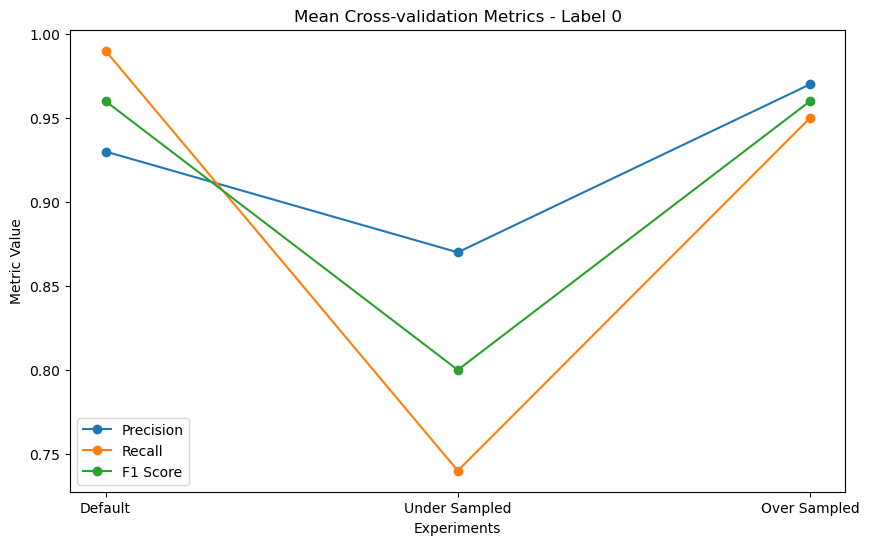

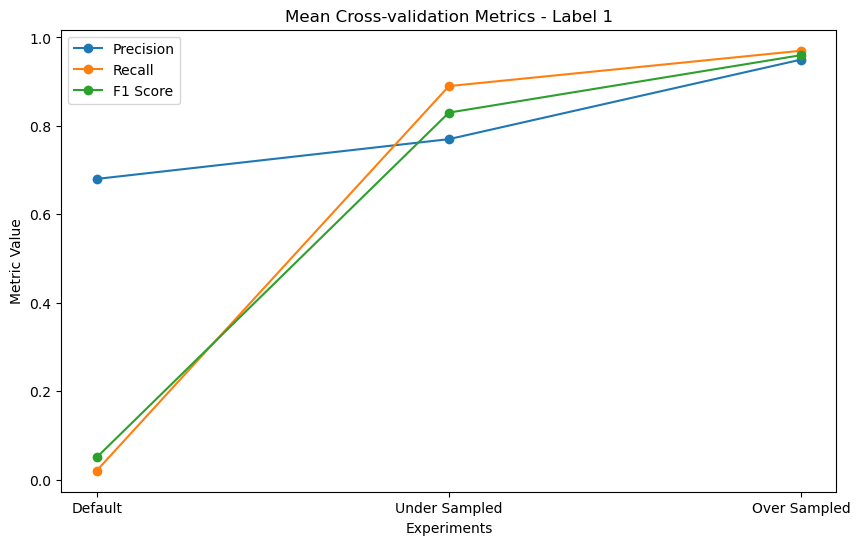

In [10]:
import matplotlib.pyplot as plt
import numpy as np
#Agg with eth

# Define the experiments and labels
experiments = ['Default', 'Under Sampled', 'Over Sampled']
labels = ['Label 0', 'Label 1']

# Define the performance metrics for each experiment and label
precision = np.array([[0.93, 0.68], [0.87, 0.77], [0.97, 0.95]])
recall = np.array([[0.99, 0.02], [0.74, 0.89], [0.95, 0.97]])
f1_score = np.array([[0.96, 0.05], [0.80, 0.83], [0.96, 0.96]])

# Set the x-axis positions
x = np.arange(len(experiments))

# Plot precision, recall, and F1 score for Label 0
plt.figure(figsize=(10, 6))
plt.plot(x, precision[:, 0], marker='o', label='Precision')
plt.plot(x, recall[:, 0], marker='o', label='Recall')
plt.plot(x, f1_score[:, 0], marker='o', label='F1 Score')
plt.xlabel('Experiments')
plt.ylabel('Metric Value')
plt.title('Mean Cross-validation Metrics - Label 0')
plt.xticks(x, experiments)
plt.legend()
plt.show()

# Plot precision, recall, and F1 score for Label 1
plt.figure(figsize=(10, 6))
plt.plot(x, precision[:, 1], marker='o', label='Precision')
plt.plot(x, recall[:, 1], marker='o', label='Recall')
plt.plot(x, f1_score[:, 1], marker='o', label='F1 Score')
plt.xlabel('Experiments')
plt.ylabel('Metric Value')
plt.title('Mean Cross-validation Metrics - Label 1')
plt.xticks(x, experiments)
plt.legend()
plt.show()

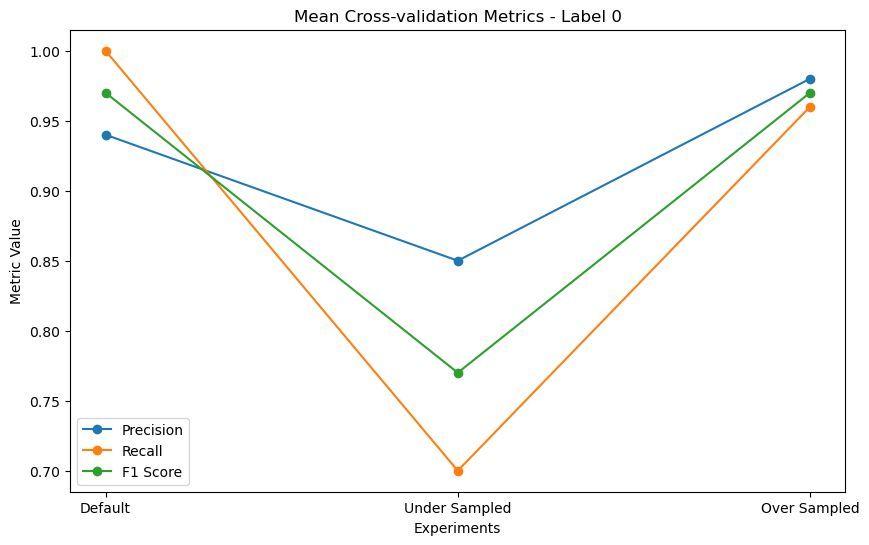

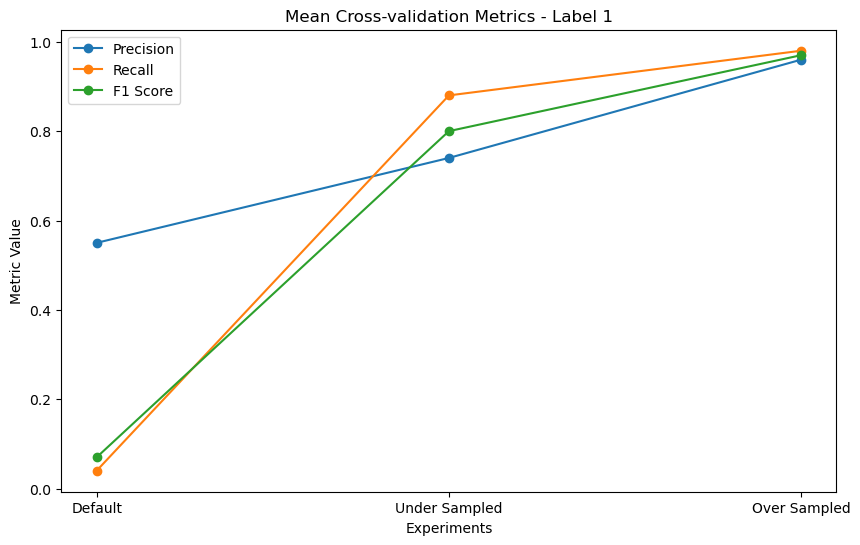

In [11]:
#Agg without eth

# Define the experiments and labels
experiments = ['Default', 'Under Sampled', 'Over Sampled']
labels = ['Label 0', 'Label 1']

# Define the performance metrics for each experiment and label
precision = np.array([[0.94, 0.55],
                     [0.85, 0.74],
                     [0.98, 0.96]])

recall = np.array([[1.00, 0.04],
                  [0.70, 0.88],
                  [0.96, 0.98]])

f1_score = np.array([[0.97, 0.07],
                     [0.77, 0.80],
                     [0.97, 0.97]])

# Set the x-axis positions
x = np.arange(len(experiments))

# Plot precision, recall, and F1 score for Label 0
plt.figure(figsize=(10, 6))
plt.plot(x, np.round(precision[:, 0], 2), marker='o', label='Precision')
plt.plot(x, np.round(recall[:, 0], 2), marker='o', label='Recall')
plt.plot(x, np.round(f1_score[:, 0], 2), marker='o', label='F1 Score')
plt.xlabel('Experiments')
plt.ylabel('Metric Value')
plt.title('Mean Cross-validation Metrics - Label 0')
plt.xticks(x, experiments)
plt.legend()
plt.show()

# Plot precision, recall, and F1 score for Label 1
plt.figure(figsize=(10, 6))
plt.plot(x, np.round(precision[:, 1], 2), marker='o', label='Precision')
plt.plot(x, np.round(recall[:, 1], 2), marker='o', label='Recall')
plt.plot(x, np.round(f1_score[:, 1], 2), marker='o', label='F1 Score')
plt.xlabel('Experiments')
plt.ylabel('Metric Value')
plt.title('Mean Cross-validation Metrics - Label 1')
plt.xticks(x, experiments)
plt.legend()
plt.show()

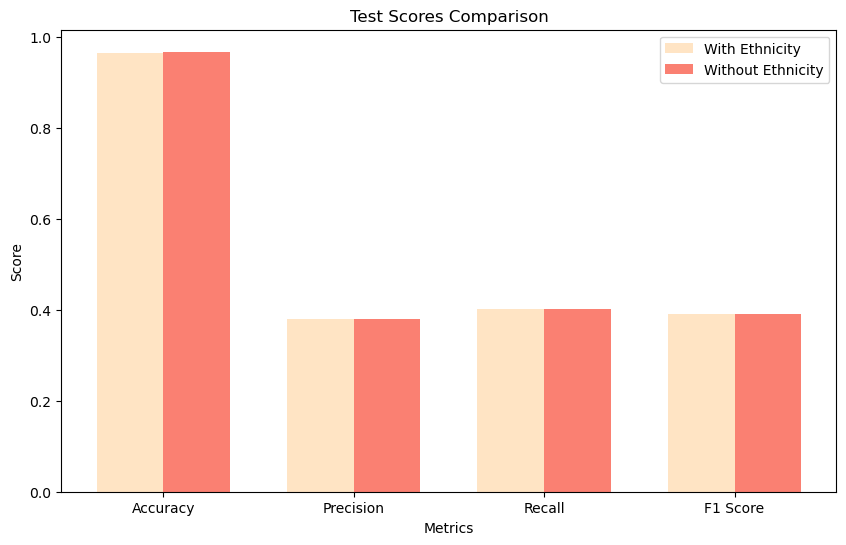

In [72]:
import matplotlib.pyplot as plt


categories = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
with_ethnicity = [0.966, 0.381, 0.402, 0.391]
without_ethnicity = [0.968, 0.381, 0.402, 0.391]

# Set the x-axis positions
x = range(len(categories))

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(x, with_ethnicity, width=0.35, label='With Ethnicity',color='bisque')
plt.bar([i + 0.35 for i in x], without_ethnicity, width=0.35, label='Without Ethnicity',color='salmon')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Test Scores Comparison')
plt.xticks([i + 0.175 for i in x], categories)
plt.legend()
plt.show()

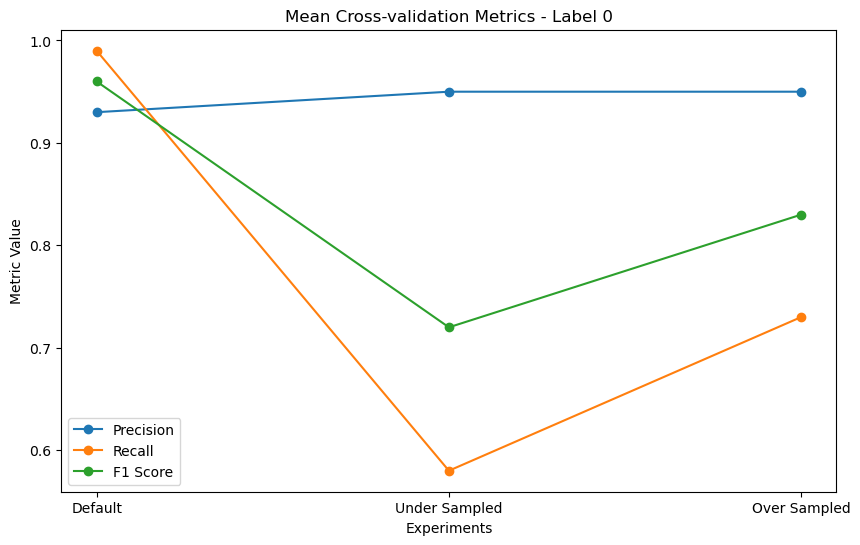

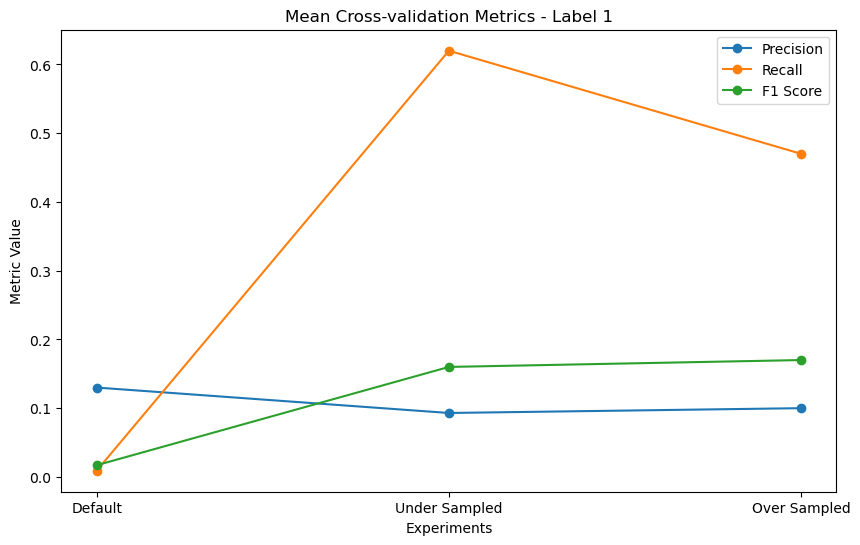

In [17]:
#labs 

# Define the experiments and labels
experiments = ['Default', 'Under Sampled', 'Over Sampled']
labels = ['Label 0', 'Label 1']

# Define the performance metrics for each experiment and label
precision = np.array([[0.93, 0.13], [0.95, 0.093], [0.95, 0.10]])
recall = np.array([[0.99, 0.009], [0.58, 0.62], [0.73, 0.47]])
f1_score = np.array([[0.96, 0.017], [0.72, 0.16], [0.83, 0.17]])

# Set the x-axis positions
x = np.arange(len(experiments))

# Plot precision, recall, and F1 score for Label 0
plt.figure(figsize=(10, 6))
plt.plot(x, precision[:, 0], marker='o', label='Precision')
plt.plot(x, recall[:, 0], marker='o', label='Recall')
plt.plot(x, f1_score[:, 0], marker='o', label='F1 Score')
plt.xlabel('Experiments')
plt.ylabel('Metric Value')
plt.title('Mean Cross-validation Metrics - Label 0')
plt.xticks(x, experiments)
plt.legend()
plt.show()

# Plot precision, recall, and F1 score for Label 1
plt.figure(figsize=(10, 6))
plt.plot(x, precision[:, 1], marker='o', label='Precision')
plt.plot(x, recall[:, 1], marker='o', label='Recall')
plt.plot(x, f1_score[:, 1], marker='o', label='F1 Score')
plt.xlabel('Experiments')
plt.ylabel('Metric Value')
plt.title('Mean Cross-validation Metrics - Label 1')
plt.xticks(x, experiments)
plt.legend()
plt.show()

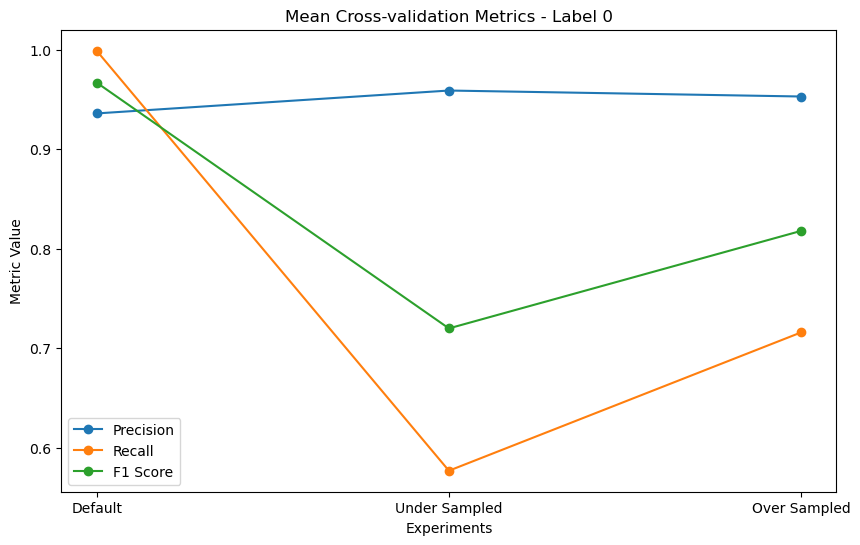

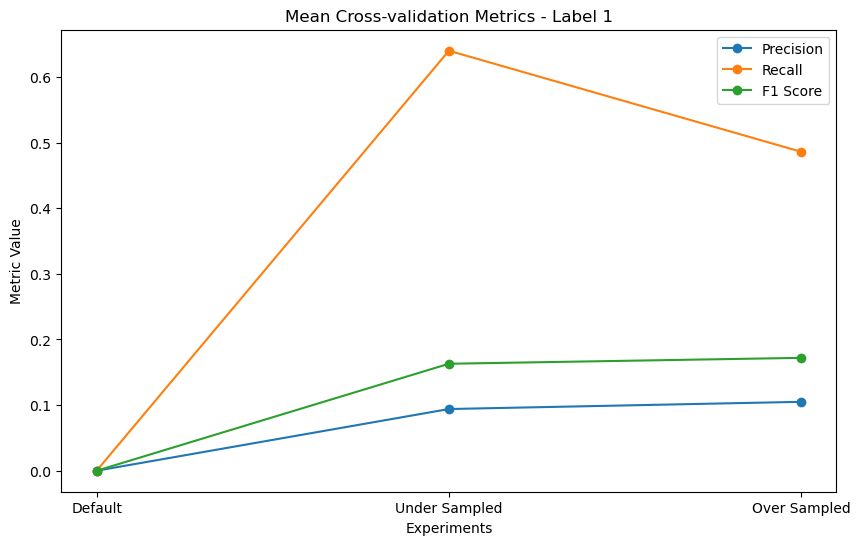

In [18]:
#Vitals 
 

# Define the experiments and labels
experiments = ['Default', 'Under Sampled', 'Over Sampled']
labels = ['Label 0', 'Label 1']

# Define the performance metrics for each experiment and label
precision = np.array([[0.936, 0.0], [0.959, 0.094], [0.953, 0.105]])
recall = np.array([[0.999, 0.0], [0.577, 0.640], [0.716, 0.486]])
f1_score = np.array([[0.967, 0.0], [0.720, 0.163], [0.818, 0.172]])

# Set the x-axis positions
x = np.arange(len(experiments))

# Plot precision, recall, and F1 score for Label 0
plt.figure(figsize=(10, 6))
plt.plot(x, precision[:, 0], marker='o', label='Precision')
plt.plot(x, recall[:, 0], marker='o', label='Recall')
plt.plot(x, f1_score[:, 0], marker='o', label='F1 Score')
plt.xlabel('Experiments')
plt.ylabel('Metric Value')
plt.title('Mean Cross-validation Metrics - Label 0')
plt.xticks(x, experiments)
plt.legend()
plt.show()

# Plot precision, recall, and F1 score for Label 1
plt.figure(figsize=(10, 6))
plt.plot(x, precision[:, 1], marker='o', label='Precision')
plt.plot(x, recall[:, 1], marker='o', label='Recall')
plt.plot(x, f1_score[:, 1], marker='o', label='F1 Score')
plt.xlabel('Experiments')
plt.ylabel('Metric Value')
plt.title('Mean Cross-validation Metrics - Label 1')
plt.xticks(x, experiments)
plt.legend()
plt.show()


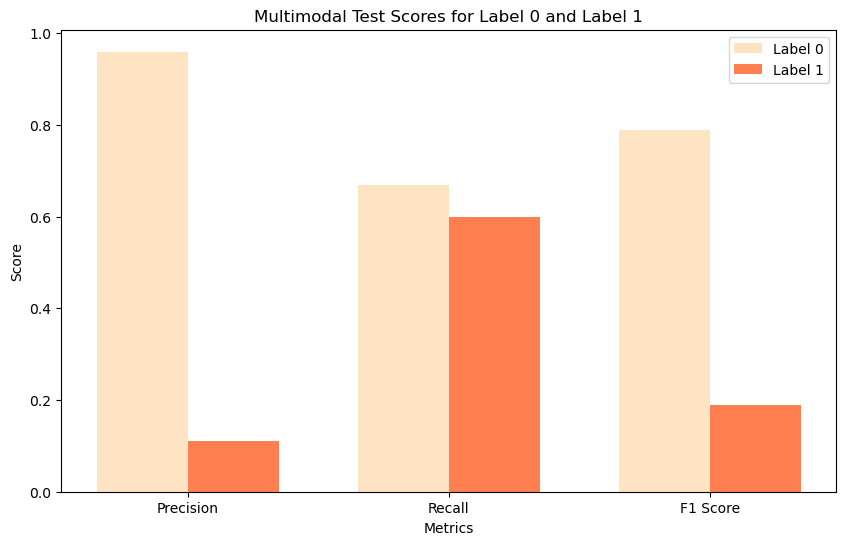

In [107]:
# Multimodal 

label0_precision = 0.96
label0_recall = 0.67
label0_f1_score = 0.79

label1_precision = 0.11
label1_recall = 0.60
label1_f1_score = 0.19

# Set the x-axis positions for the bars
x = np.arange(3)

# Set the width of each bar
bar_width = 0.35

# Plot the precision, recall, and F1 scores for label 0 and label 1
plt.figure(figsize=(10, 6))
plt.bar(x, [label0_precision, label0_recall, label0_f1_score], bar_width, label='Label 0',color='bisque')
plt.bar(x + bar_width, [label1_precision, label1_recall, label1_f1_score], bar_width, label='Label 1',color='coral')

# Add labels, title, and legend
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Multimodal Test Scores for Label 0 and Label 1')
plt.xticks(x + bar_width/2, ['Precision', 'Recall', 'F1 Score'])
plt.legend()

# Show the plot
plt.show()


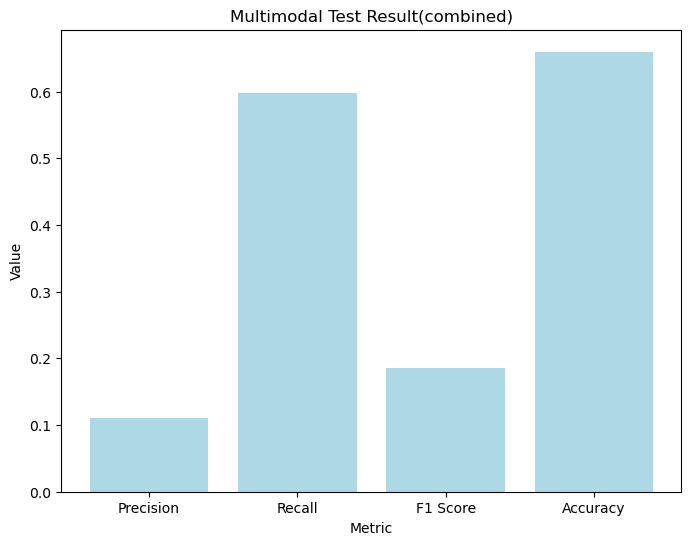

In [105]:
#Multimodal

# Define the performance metrics
precision = 0.110
recall = 0.598
f1_score = 0.186
acc=0.66

# Set the x-axis positions for the bars
x = ['Precision', 'Recall', 'F1 Score','Accuracy' ]

# Set the corresponding metric values
y = [precision, recall, f1_score,acc]

# Plot the bar graph
plt.figure(figsize=(8, 6))
plt.bar(x, y,color='lightblue')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Multimodal Test Result(combined)')
plt.show()

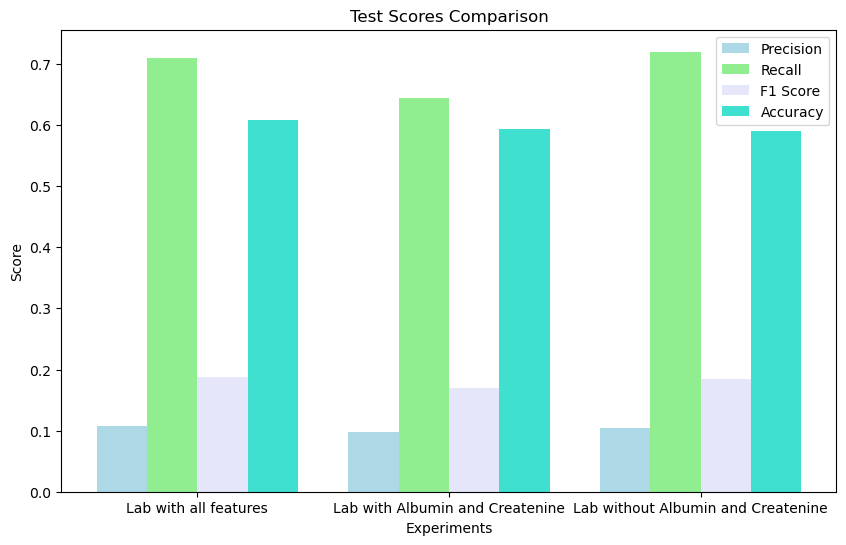

In [123]:
# Define the experiments
experiments = ['Lab with all features', 'Lab with Albumin and Createnine', 'Lab without Albumin and Createnine']

# Define the performance metrics
precision = [0.108, 0.097, 0.105]
recall = [0.710, 0.645, 0.720]
f1_score = [0.188, 0.169, 0.184]
accuracy = [0.608, 0.594, 0.591]

# Set the x-axis positions for the bars
x = np.arange(len(experiments))

# Set the width of each bar
bar_width = 0.2

color_palette = ['lightblue', 'lightgreen', 'lavender', 'turquoise']


# Plot the metrics using pastel colors
plt.figure(figsize=(10, 6))
plt.bar(x, precision, width=bar_width, label='Precision', color=color_palette[0])
plt.bar(x + bar_width, recall, width=bar_width, label='Recall', color=color_palette[1])
plt.bar(x + 2 * bar_width, f1_score, width=bar_width, label='F1 Score', color=color_palette[2])
plt.bar(x + 3 * bar_width, accuracy, width=bar_width, label='Accuracy', color=color_palette[3])

plt.xlabel('Experiments')
plt.ylabel('Score')
plt.title('Test Scores Comparison')
plt.xticks(x + 1.5 * bar_width, experiments)
plt.legend()
plt.grid(False)
plt.show()

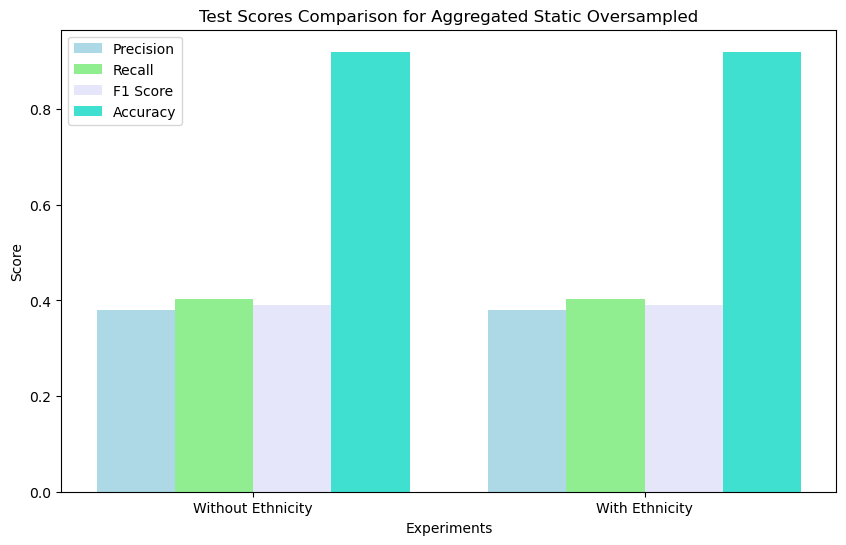

In [124]:
# Define the experiments
experiments = ['Without Ethnicity', 'With Ethnicity']

# Define the performance metrics
precision = [0.381, 0.381]
recall = [0.402, 0.402]
f1_score = [0.391, 0.391]
accuracy = [0.920, 0.920]

# Set the x-axis positions for the bars
x = np.arange(len(experiments))

# Set the width of each bar
bar_width = 0.2

# Define the color palette
color_palette = ['lightblue', 'lightgreen', 'lavender', 'turquoise']

# Plot the metrics using the specified colors
plt.figure(figsize=(10, 6))
plt.bar(x, precision, width=bar_width, label='Precision', color=color_palette[0])
plt.bar(x + bar_width, recall, width=bar_width, label='Recall', color=color_palette[1])
plt.bar(x + 2 * bar_width, f1_score, width=bar_width, label='F1 Score', color=color_palette[2])
plt.bar(x + 3 * bar_width, accuracy, width=bar_width, label='Accuracy', color=color_palette[3])

plt.xlabel('Experiments')
plt.ylabel('Score')
plt.title('Test Scores Comparison for Aggregated Static Oversampled')
plt.xticks(x + 1.5 * bar_width, experiments)
plt.legend()
plt.show()